In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
from matplotlib.gridspec import GridSpec
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

import sys, os
import warnings
from pathlib import Path

In [2]:
sys.path.append(str(Path().resolve().parent.parent))
from path_manager import MISC_DIR, FORECAST_DATA_NB, FORECAST_MODEL_RESULT_DIR, PLOT_DIR

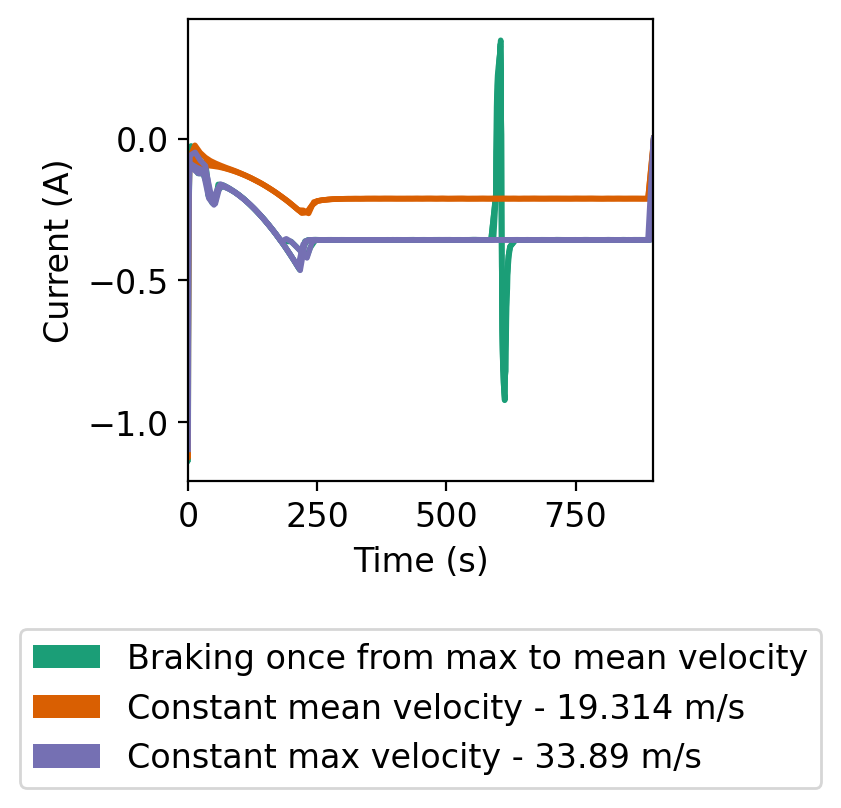

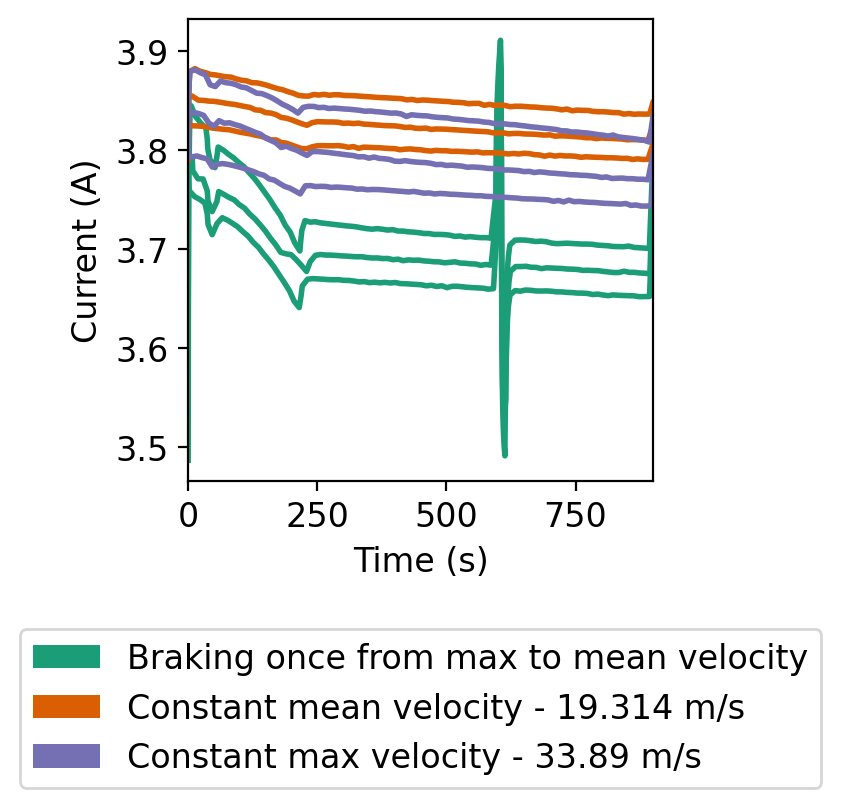

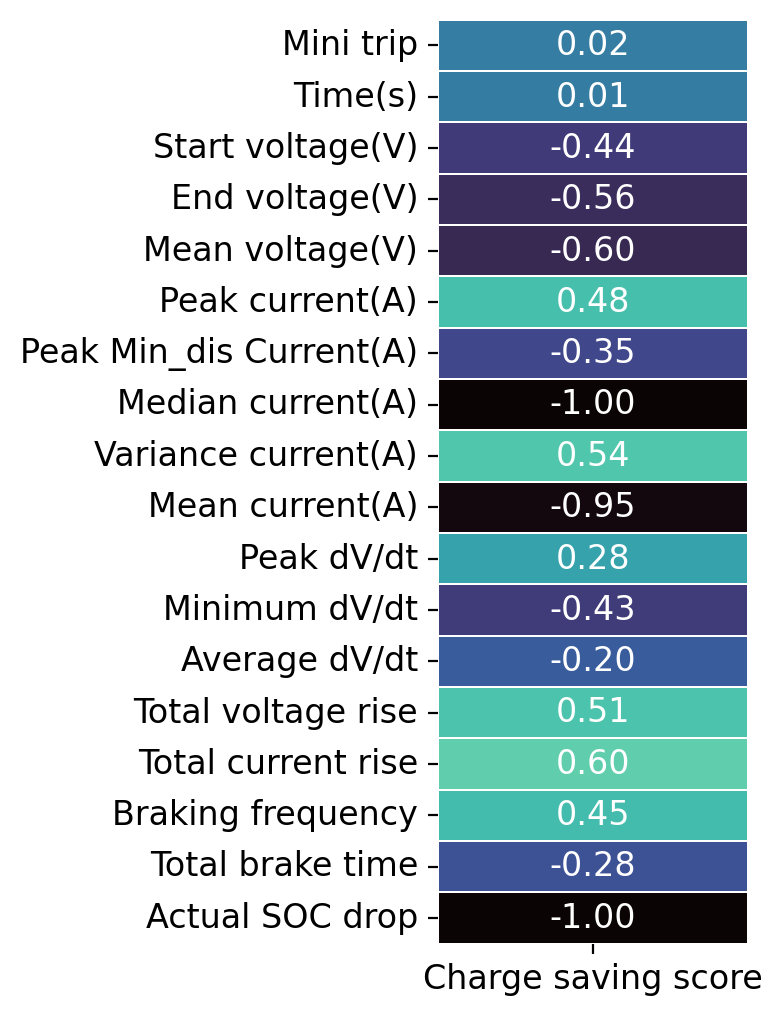

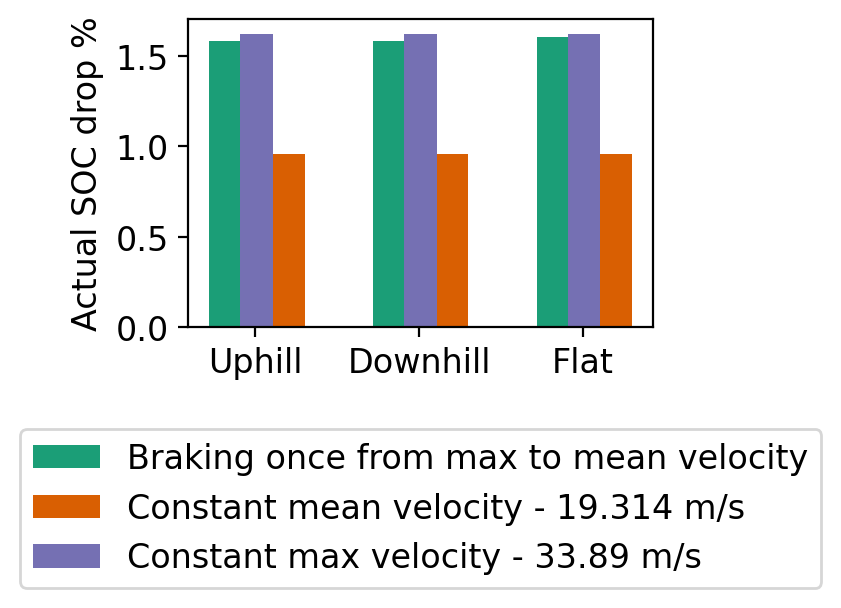

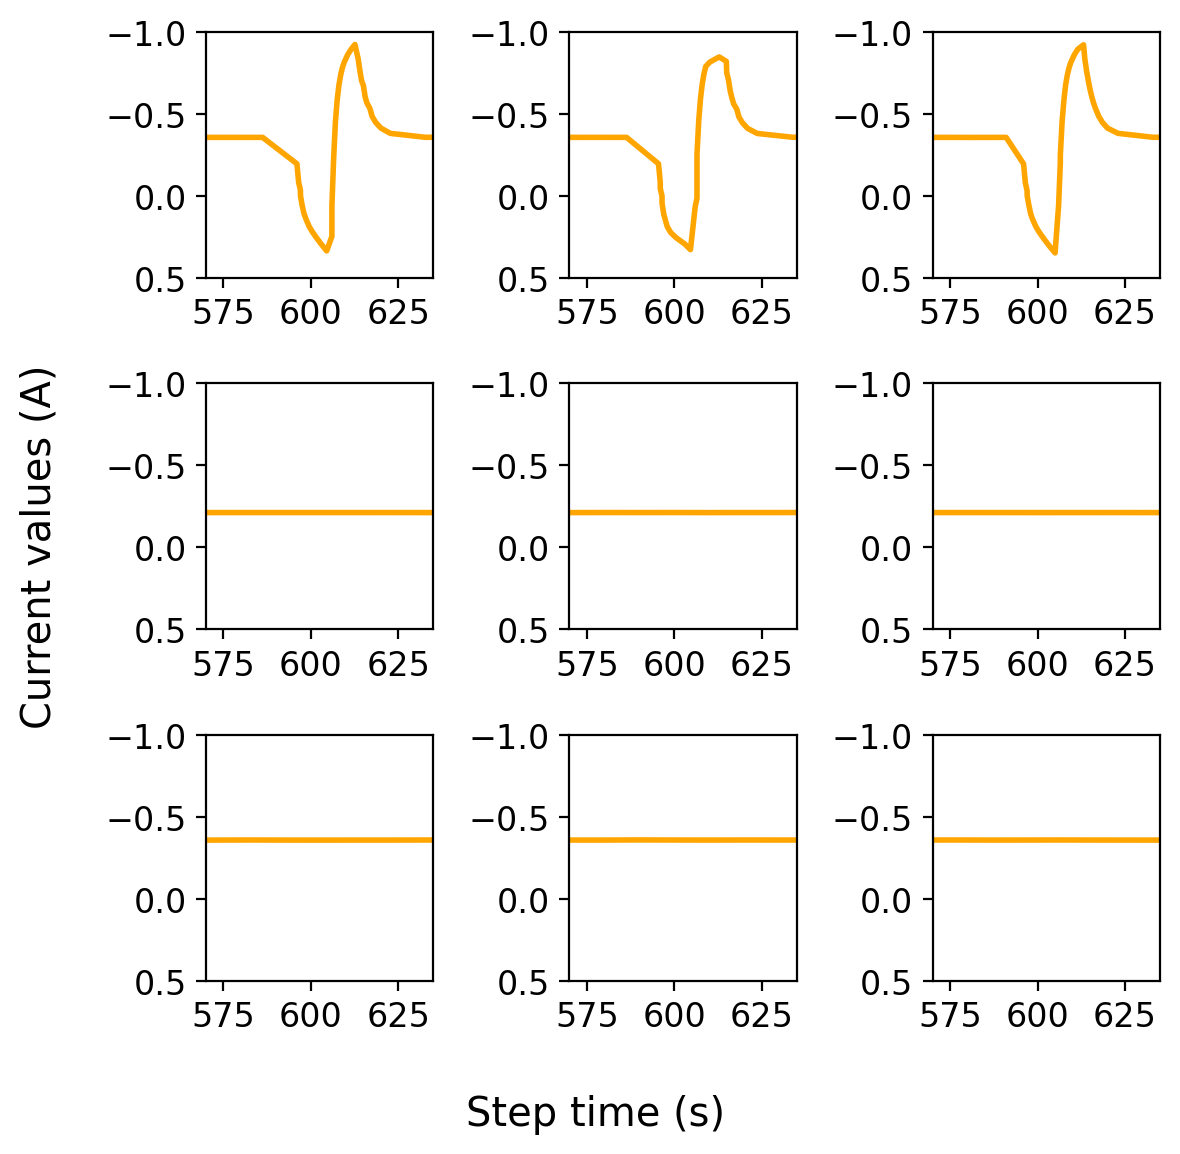

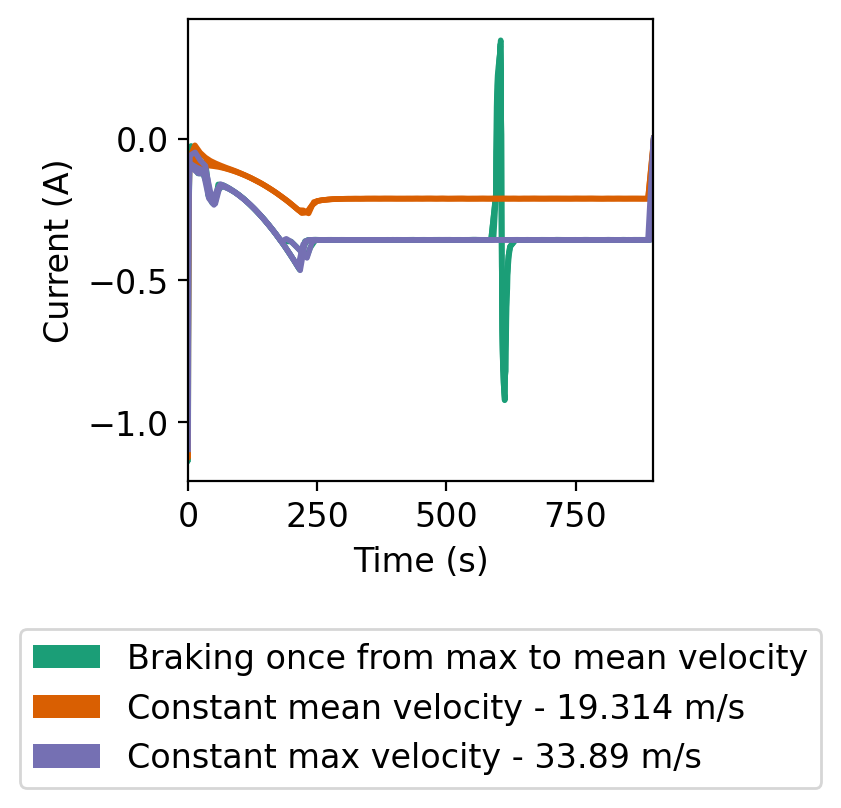

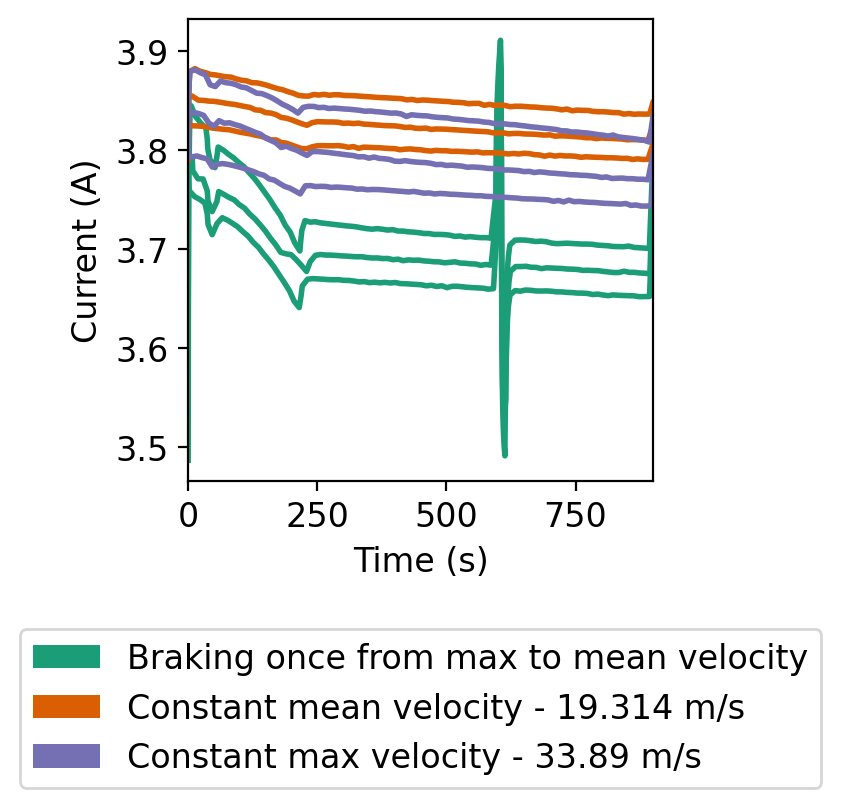

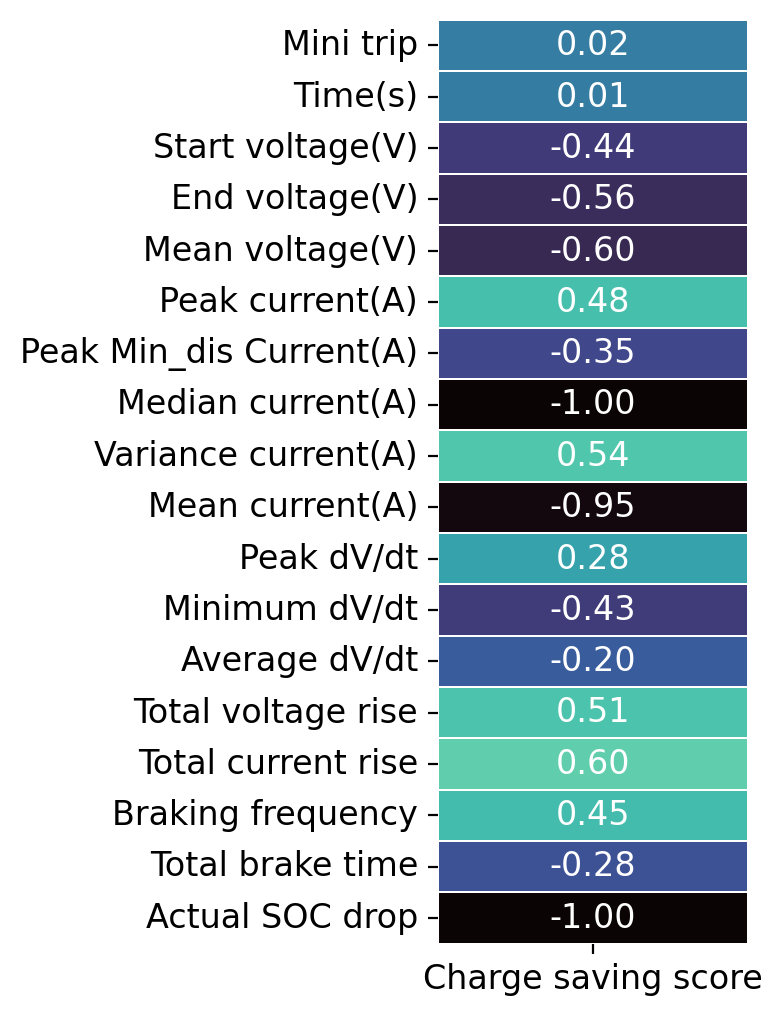

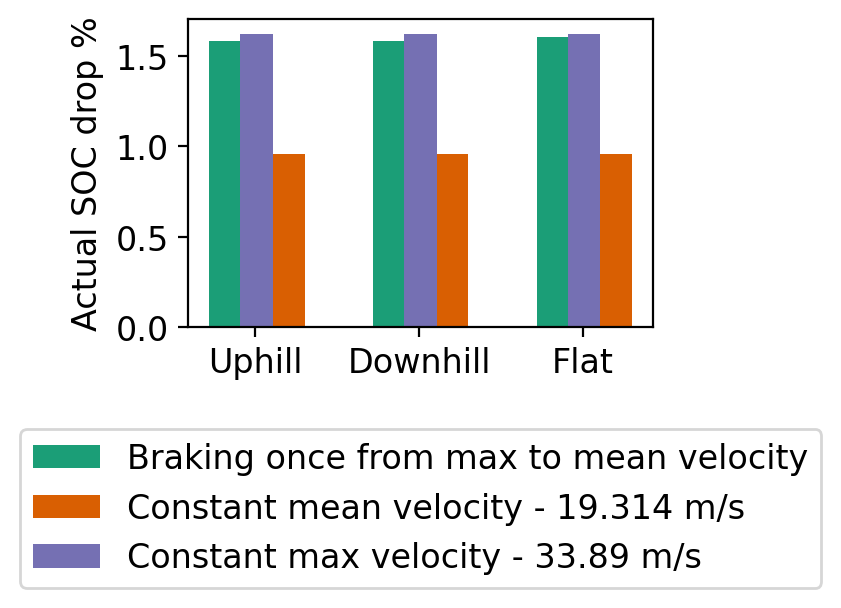

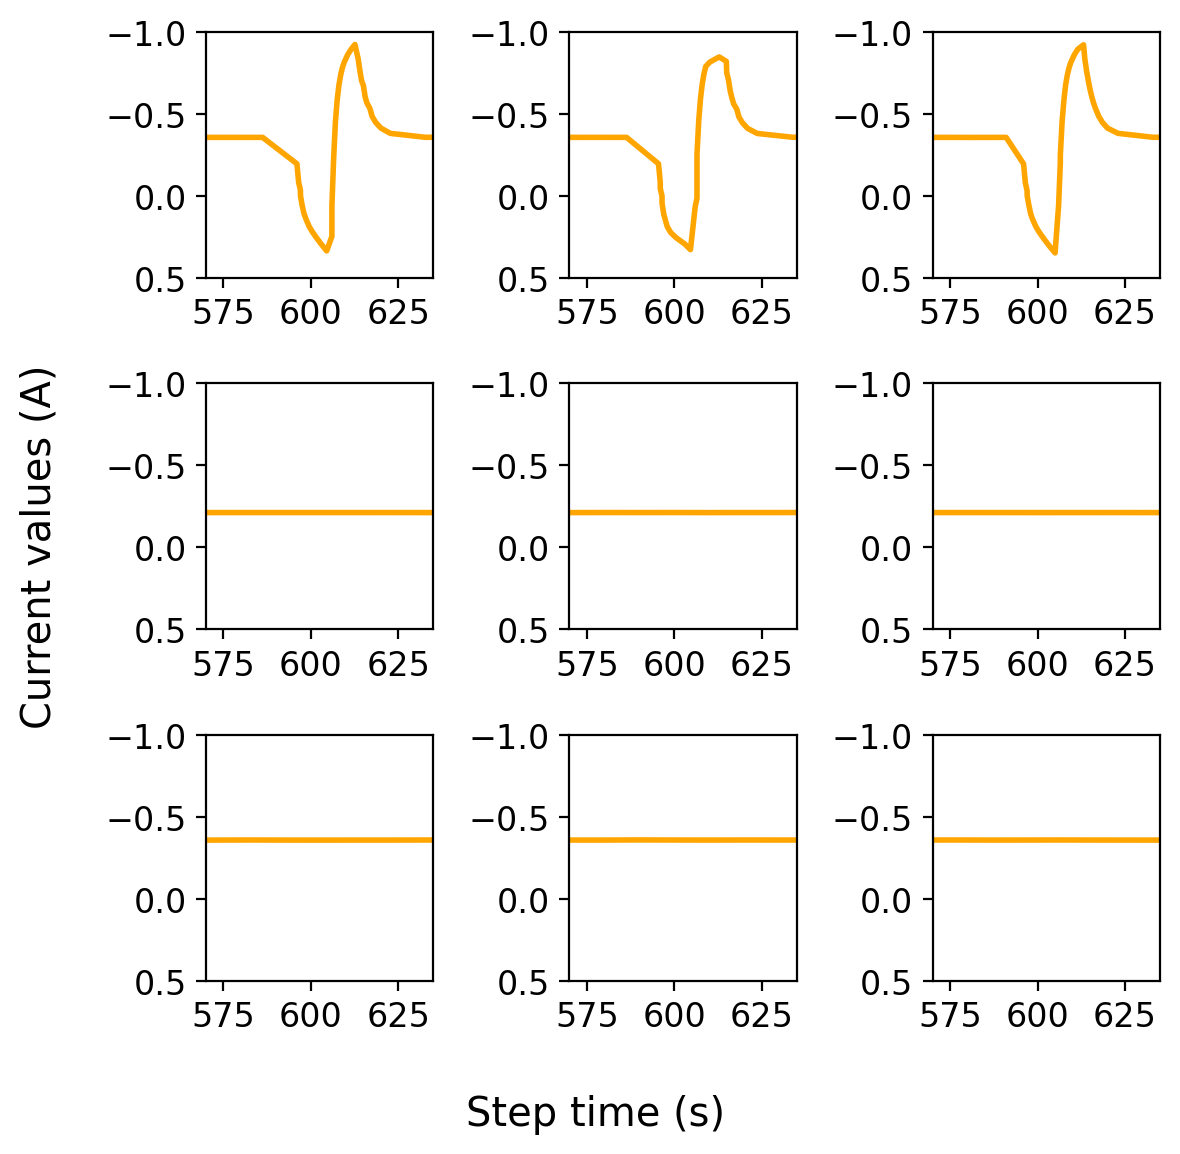

/var/folders/bv/5yzv5x3d5sb44fl8wn3sdr540000gn/T/ipykernel_46726/3217211228.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data1['Classification'].iloc[mt]= 'def_Up'
/var/folders/bv/5yzv5x3d5sb44fl8wn3sdr540000gn/T/ipykernel_46726/32172

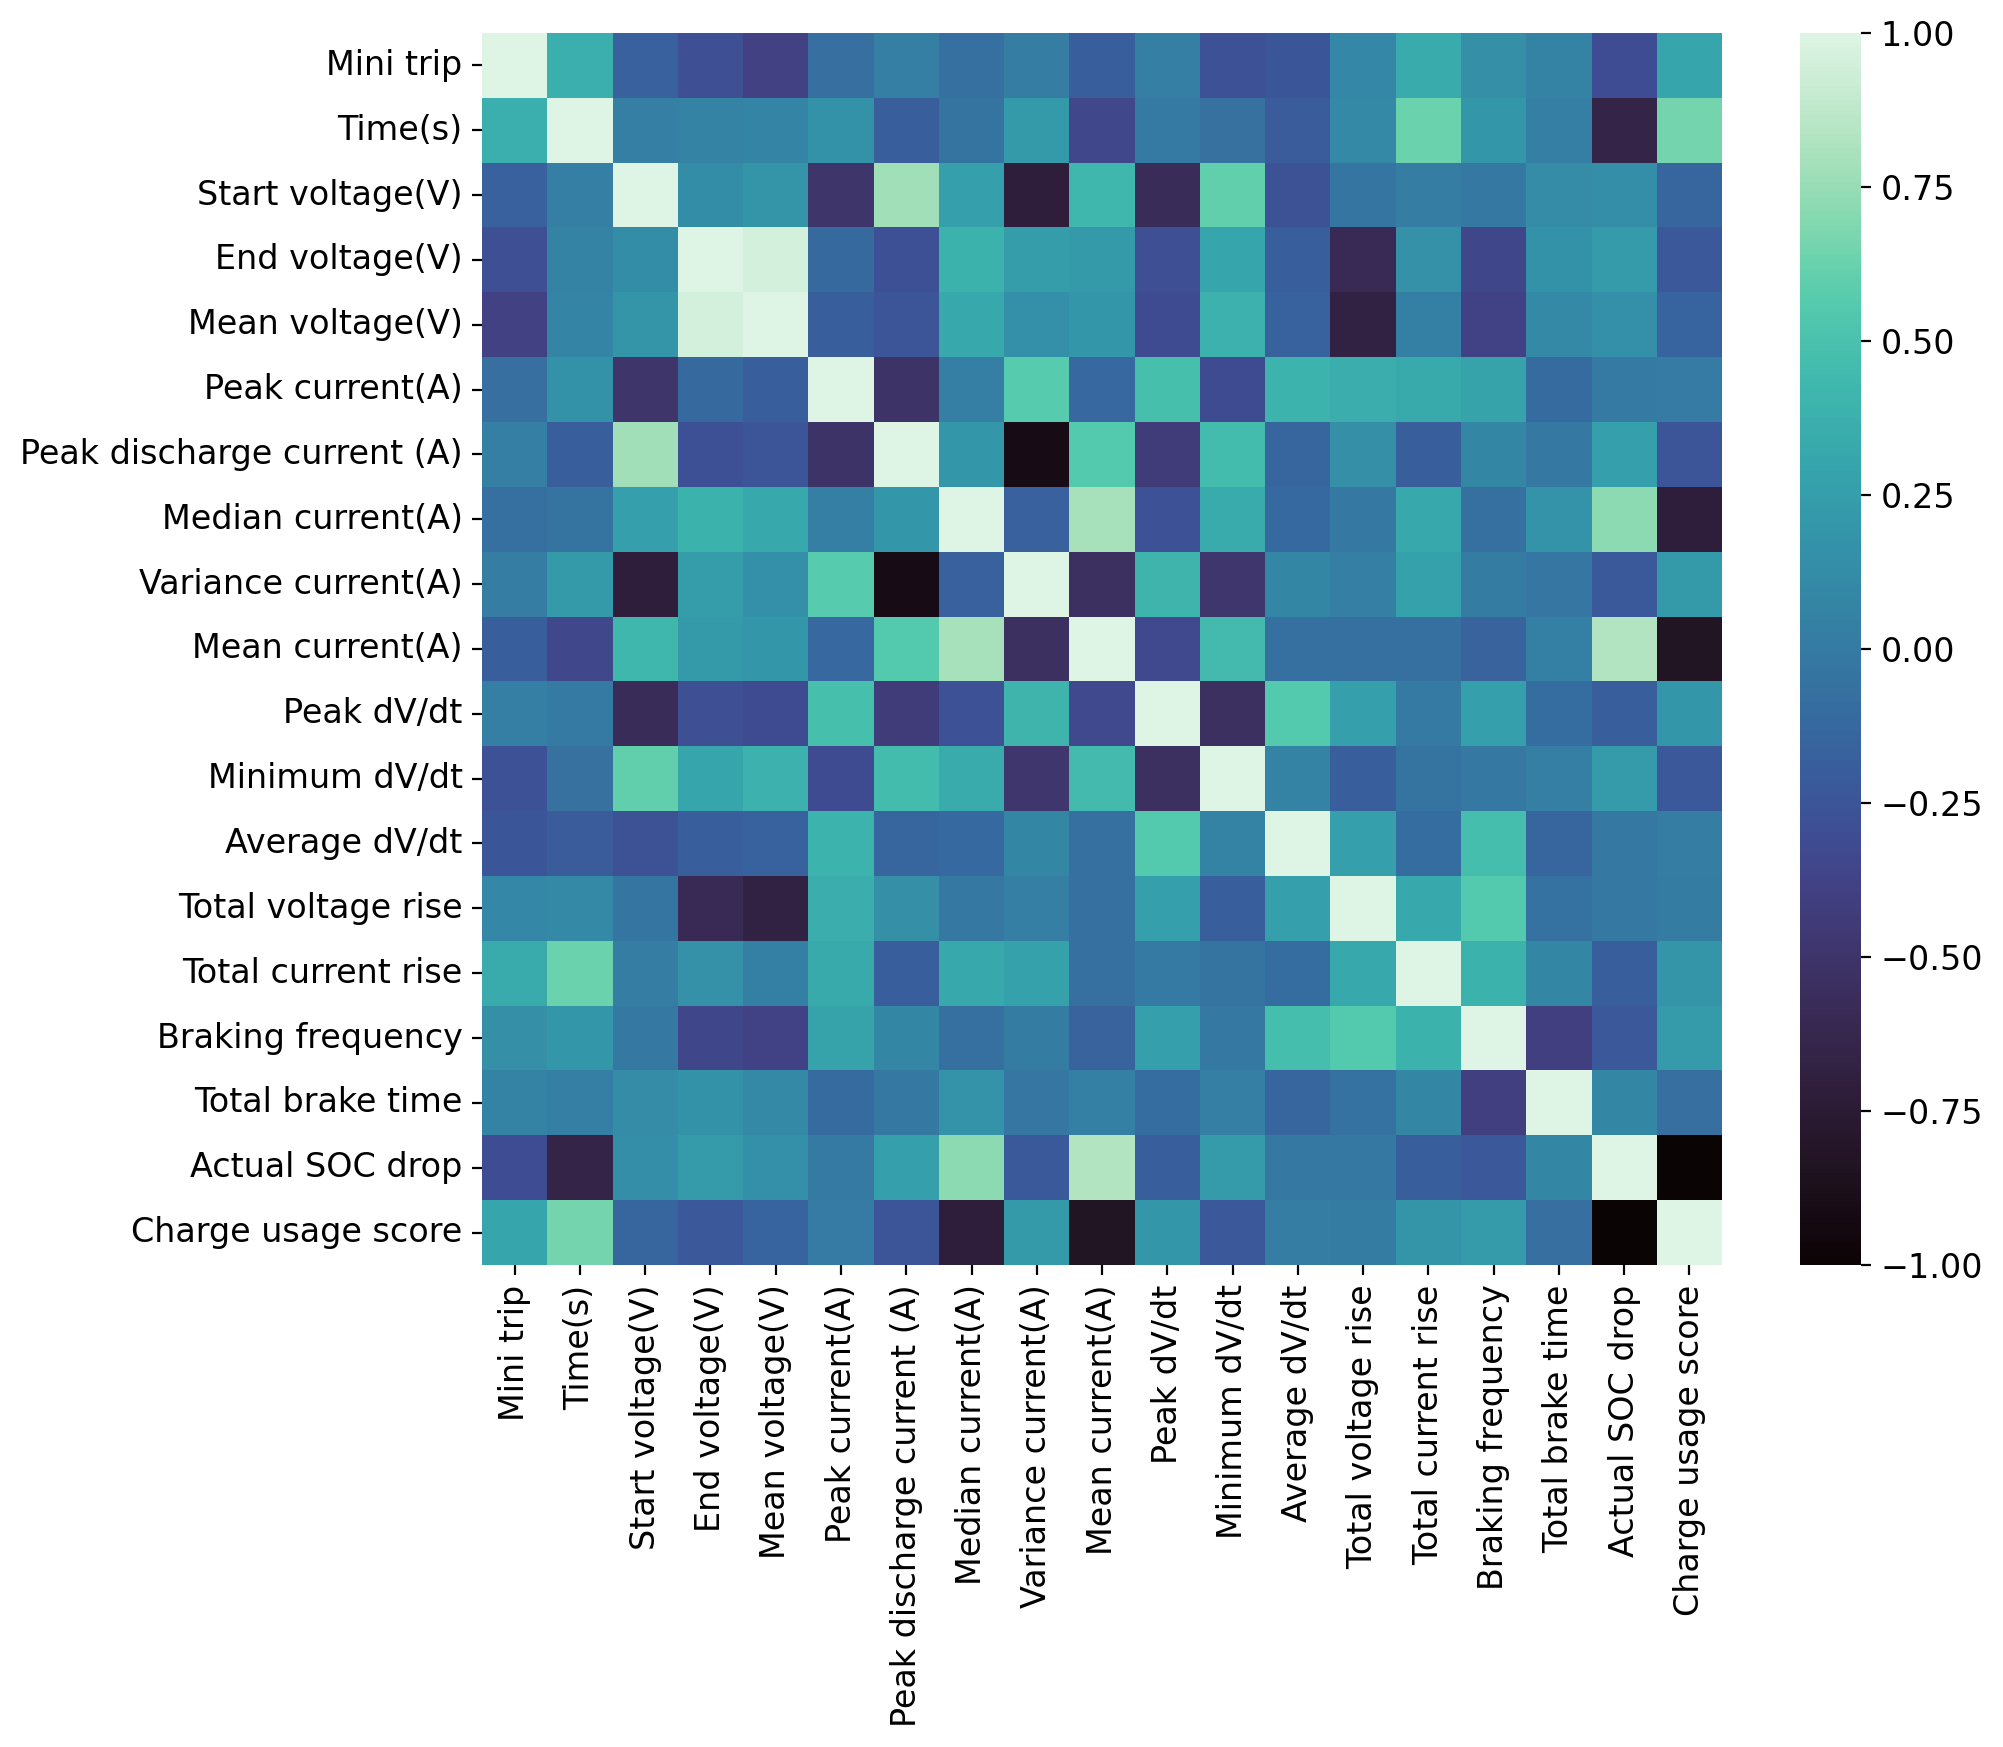

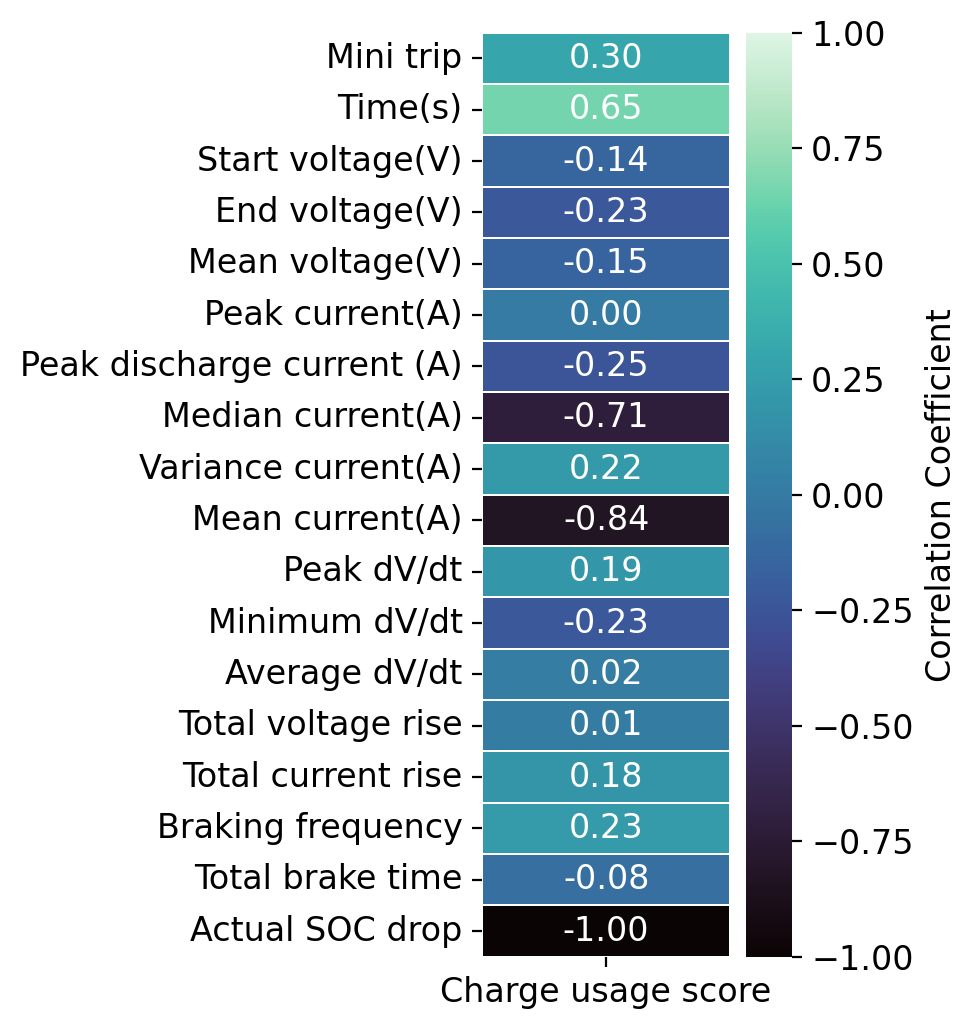

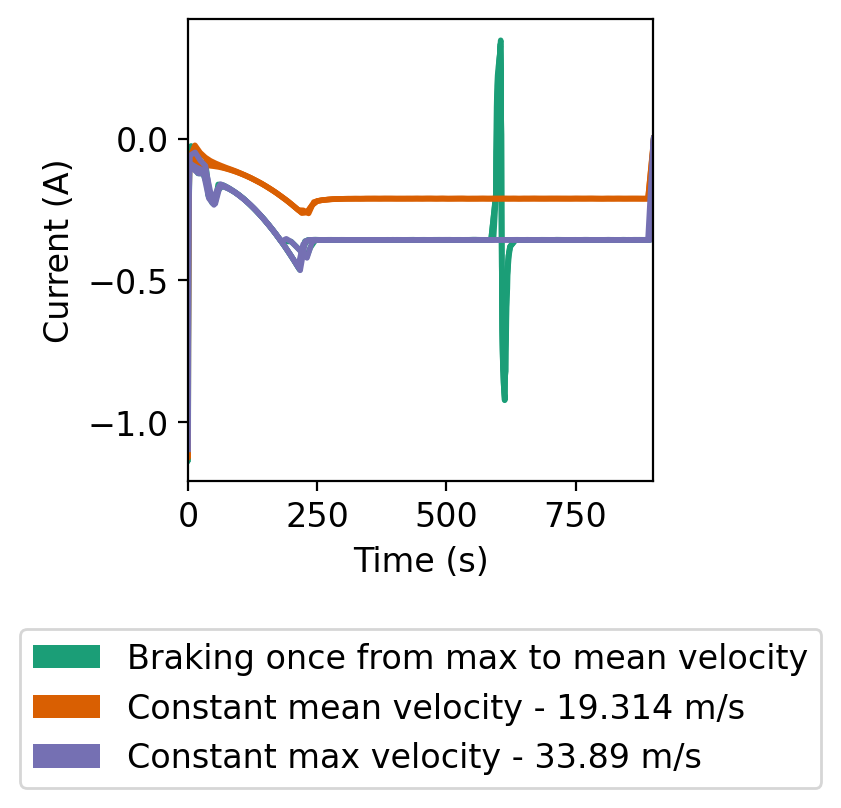

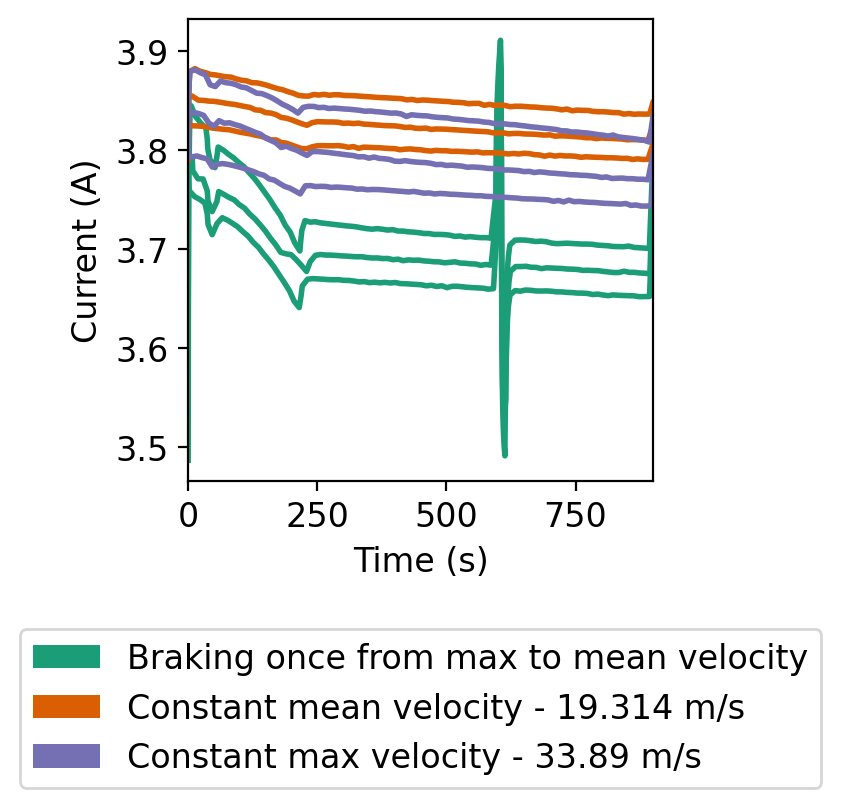

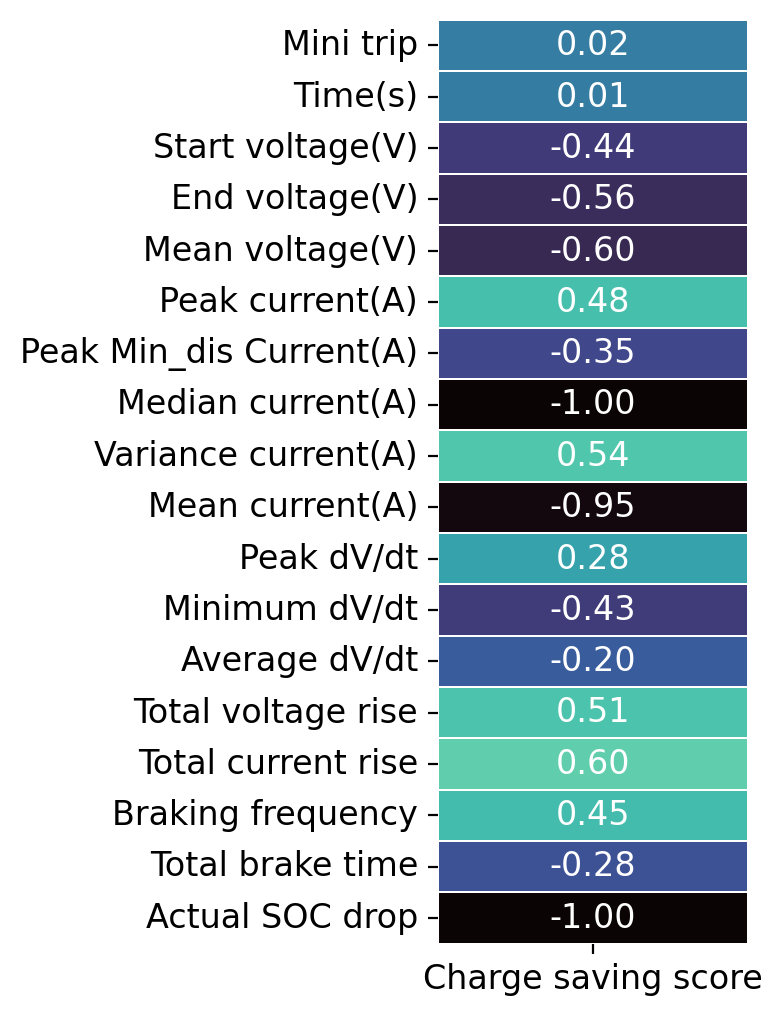

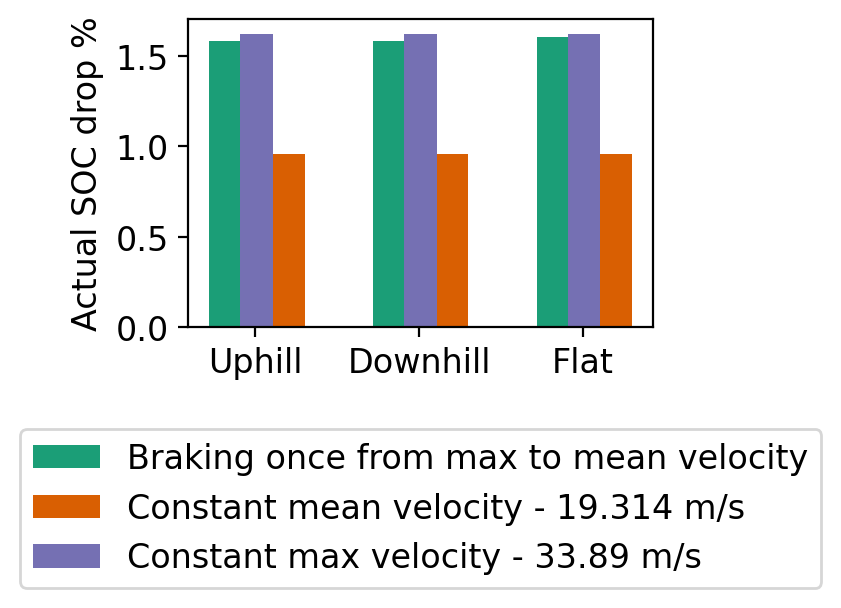

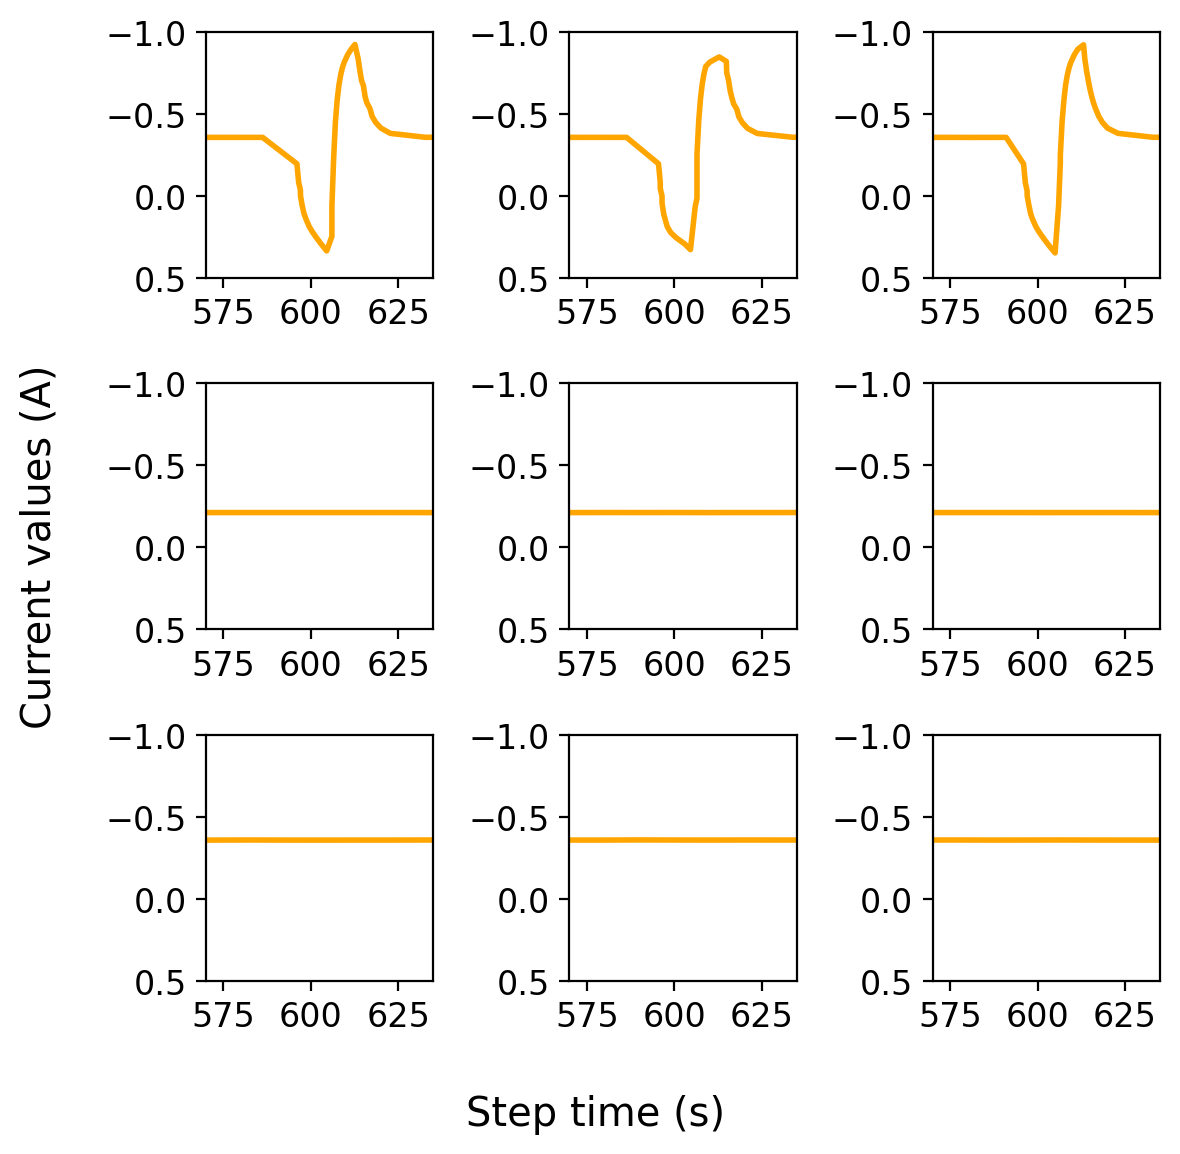

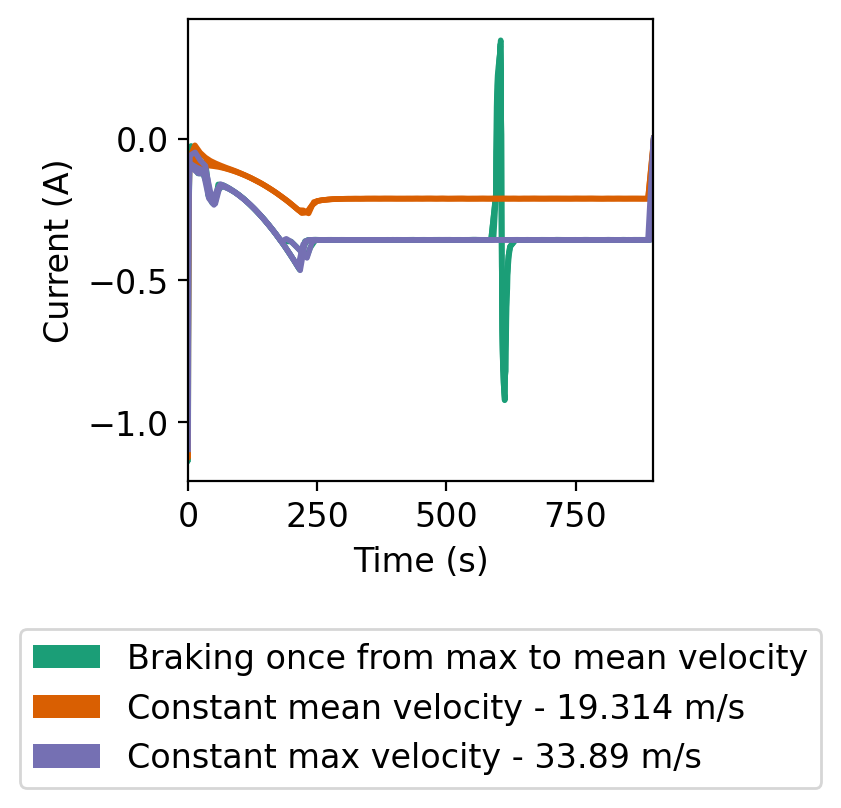

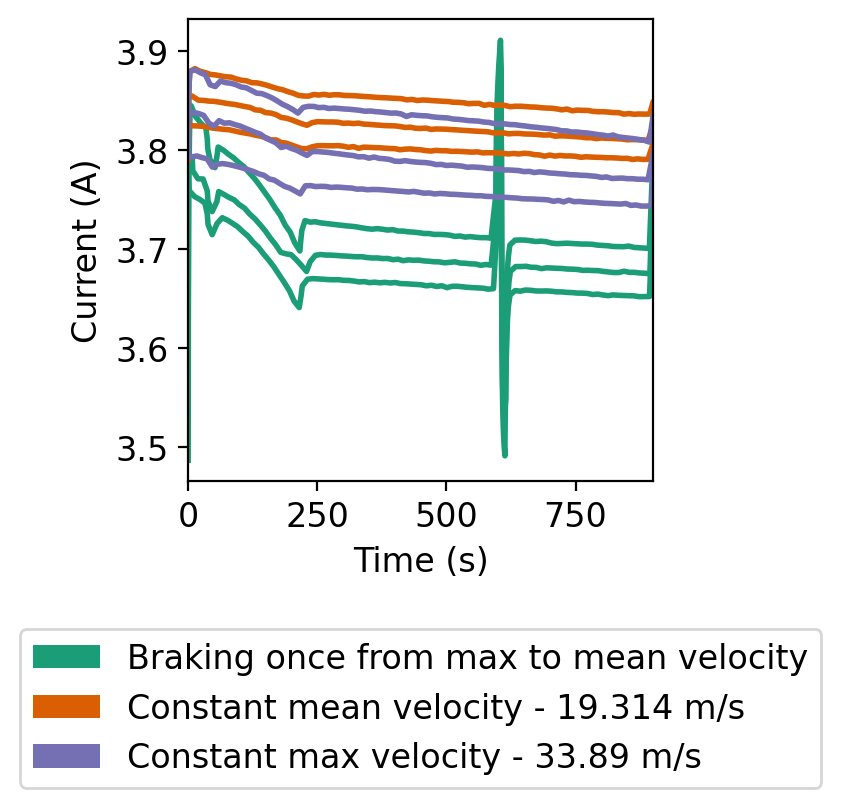

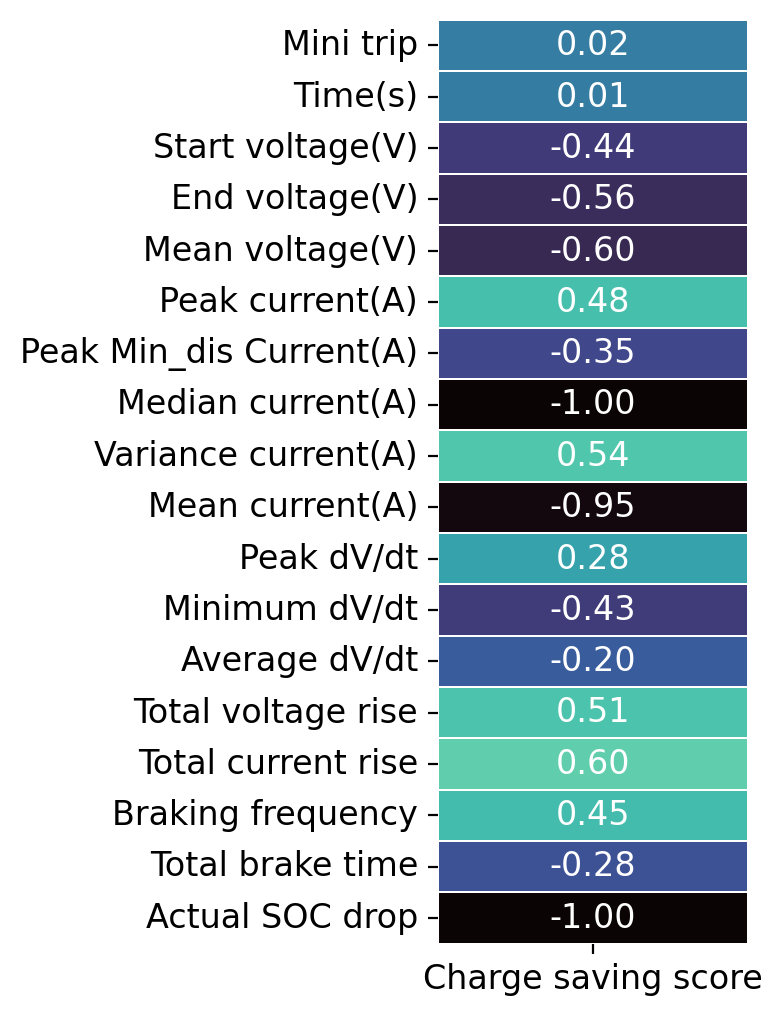

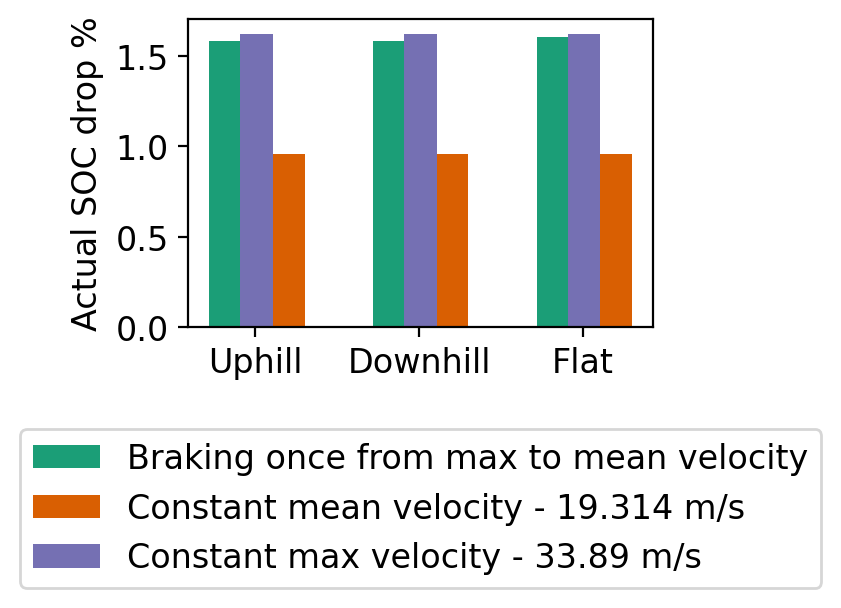

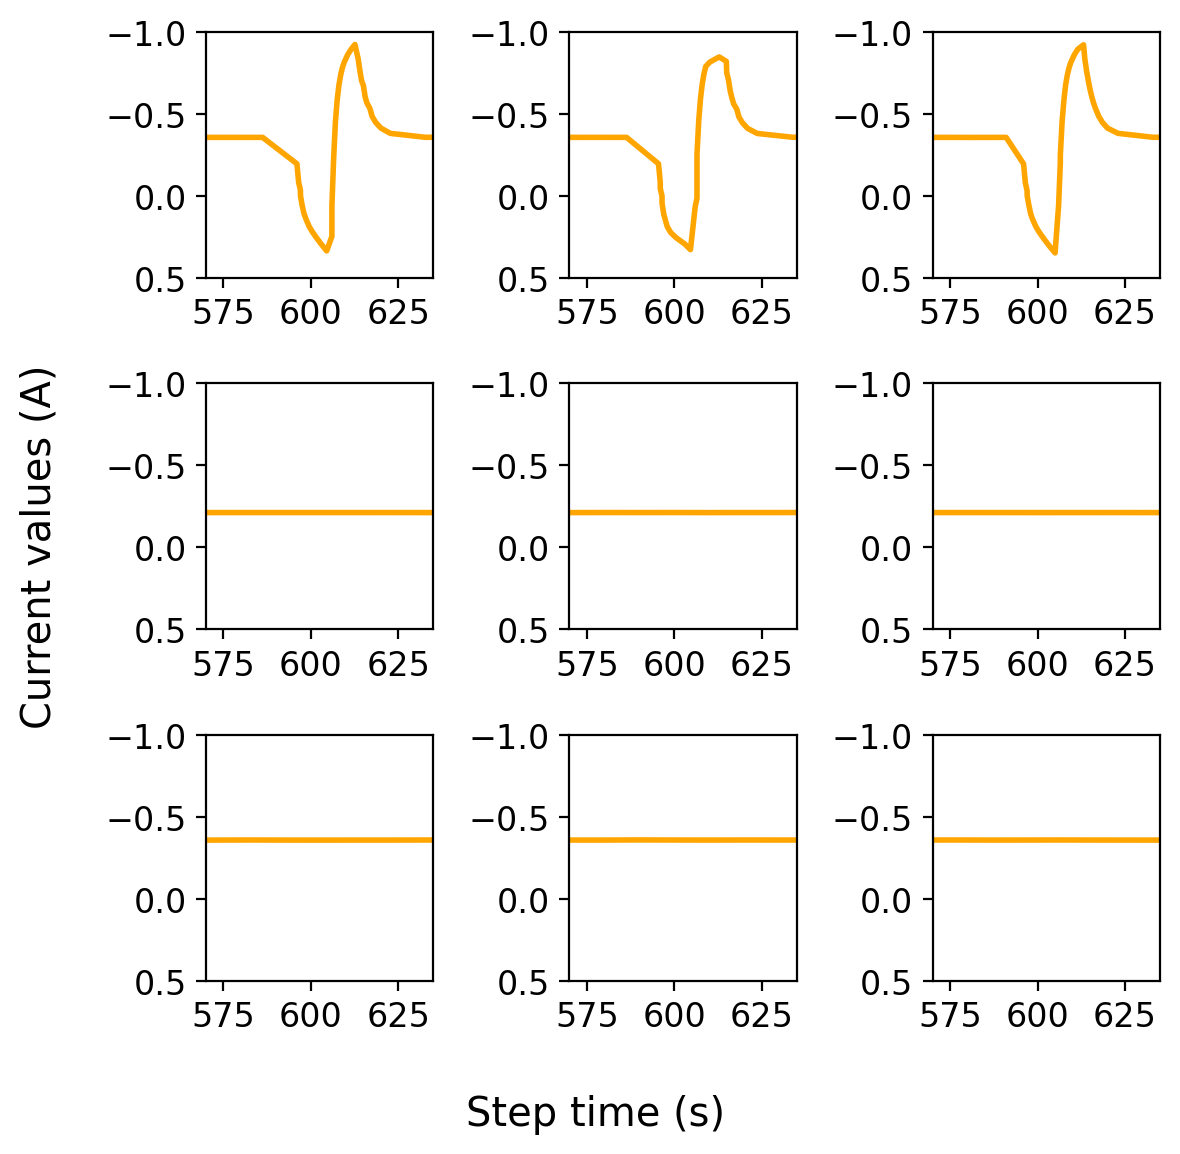

/var/folders/bv/5yzv5x3d5sb44fl8wn3sdr540000gn/T/ipykernel_46726/3217211228.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data1['Classification'].iloc[mt]= 'def_Up'
/var/folders/bv/5yzv5x3d5sb44fl8wn3sdr540000gn/T/ipykernel_46726/32172

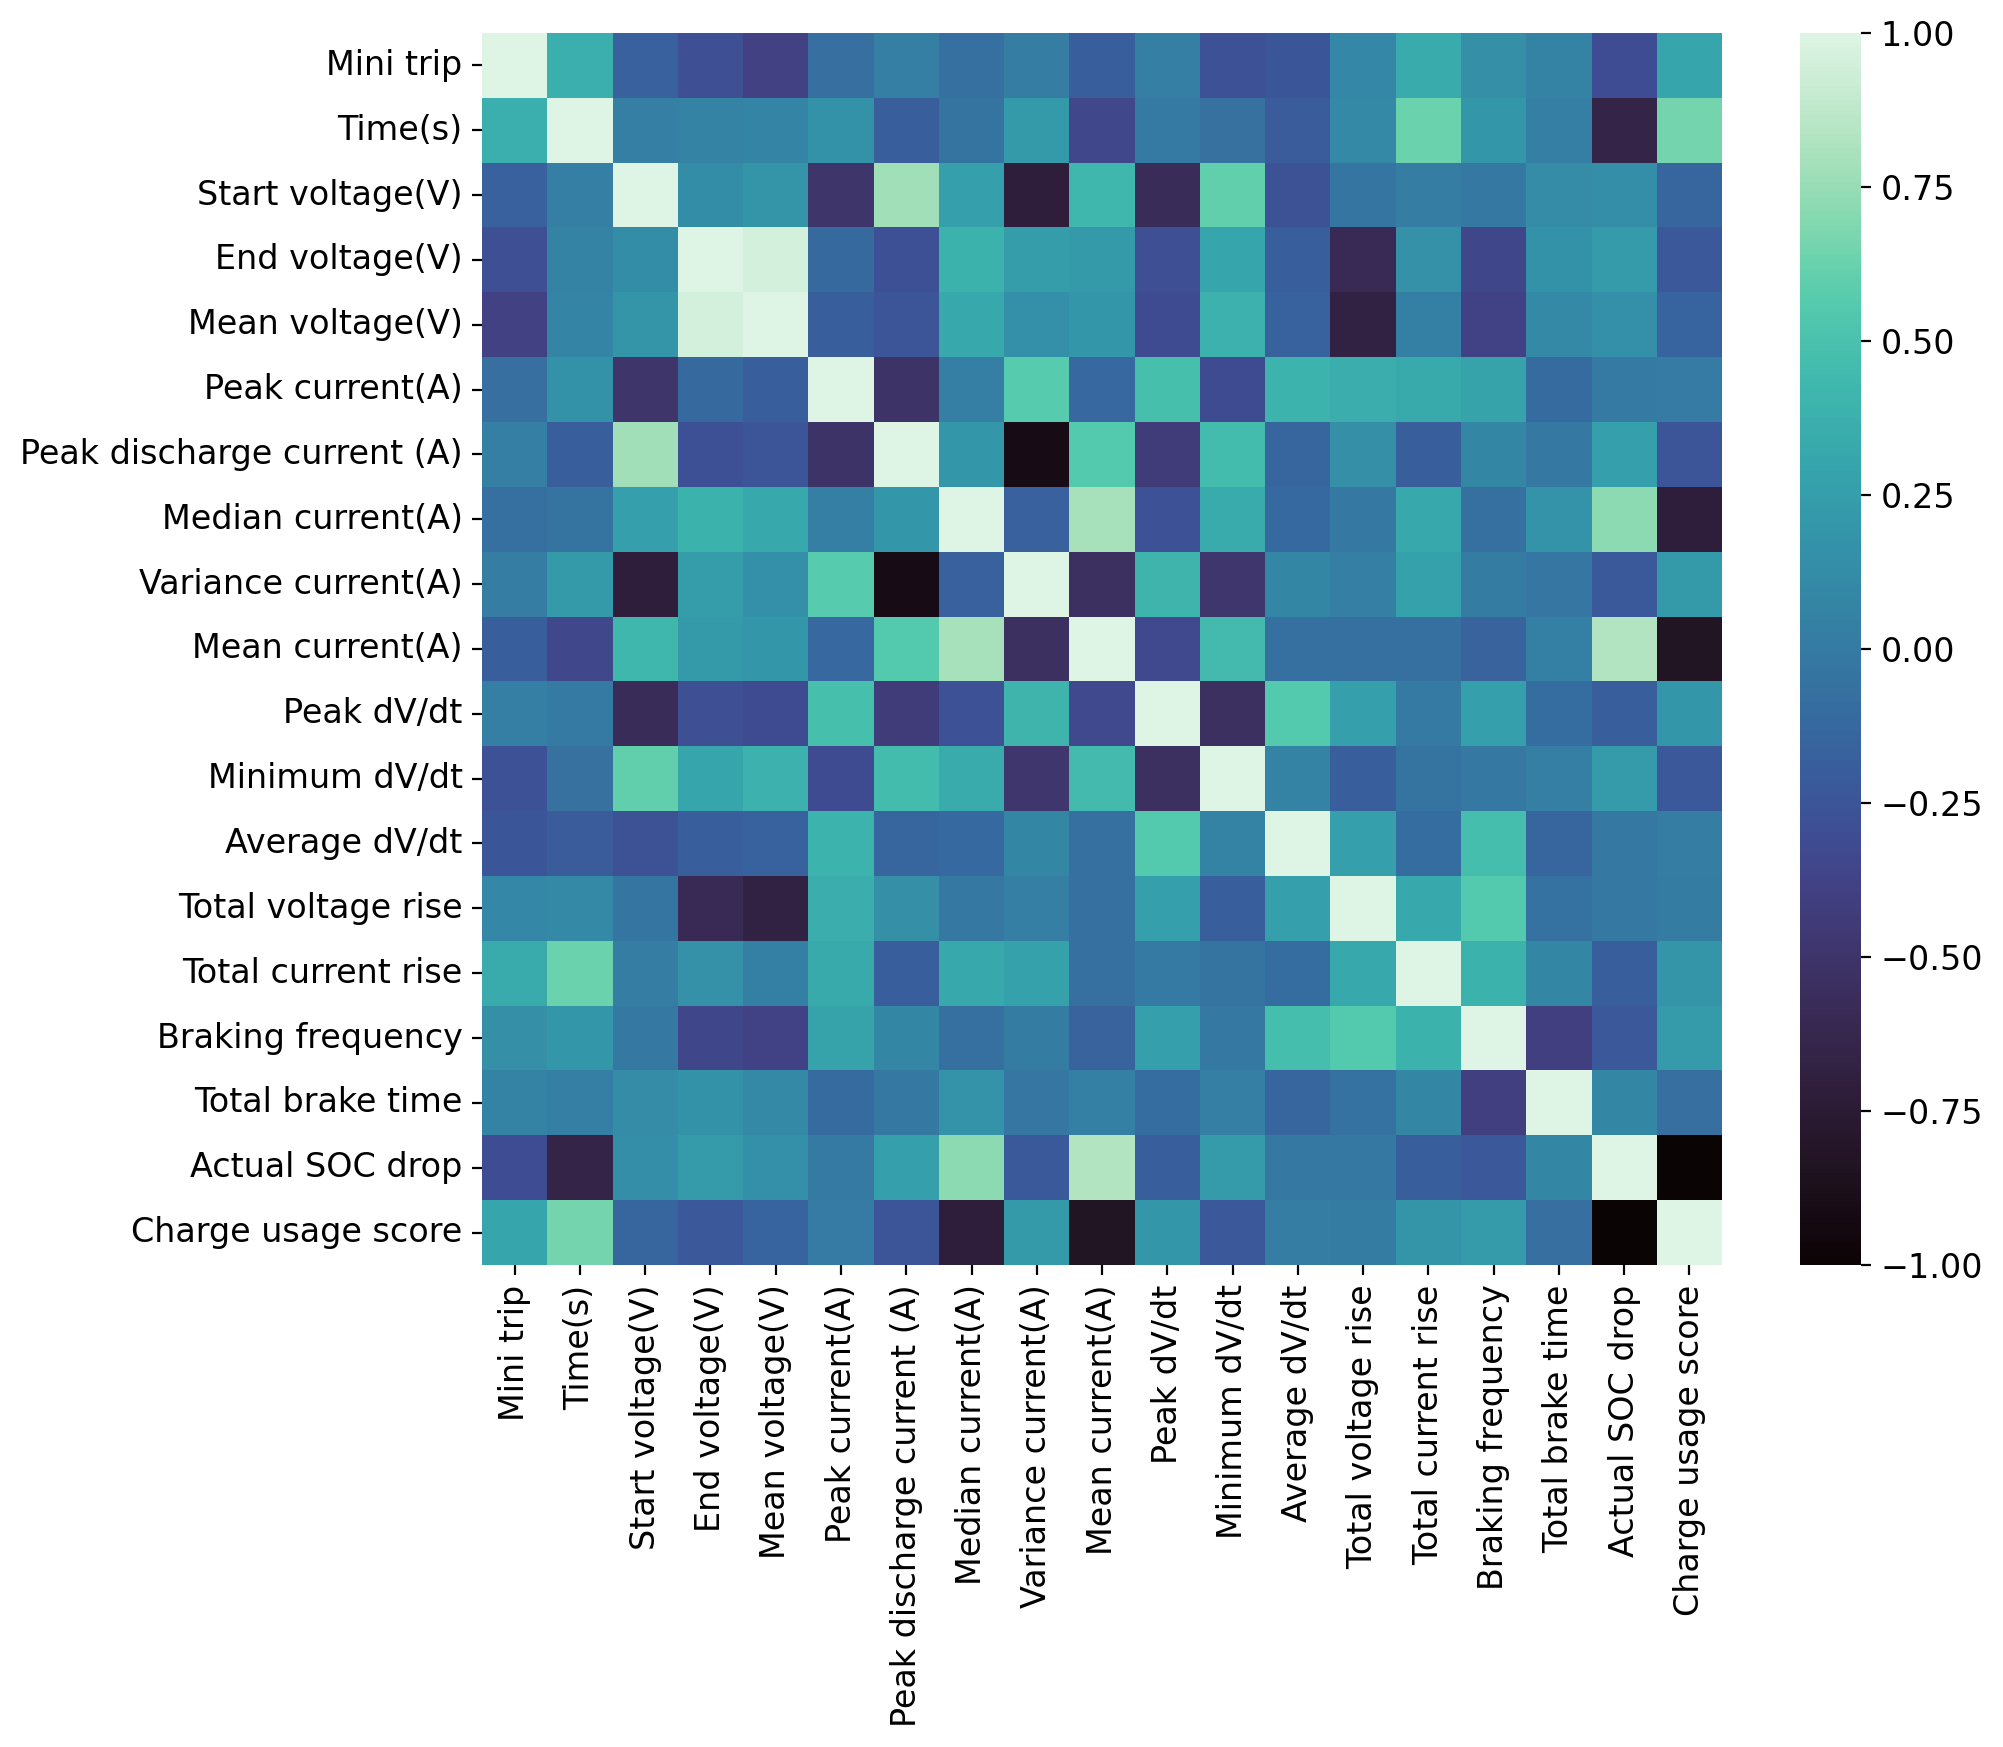

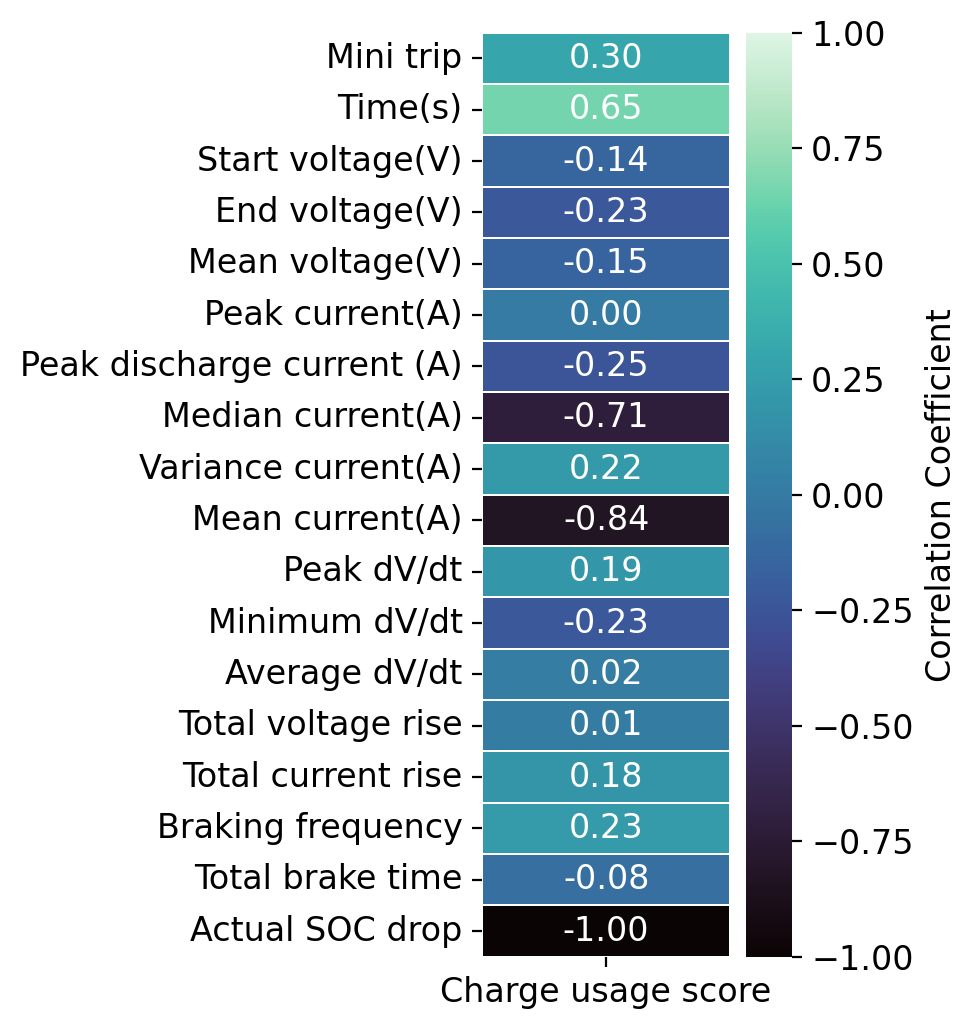

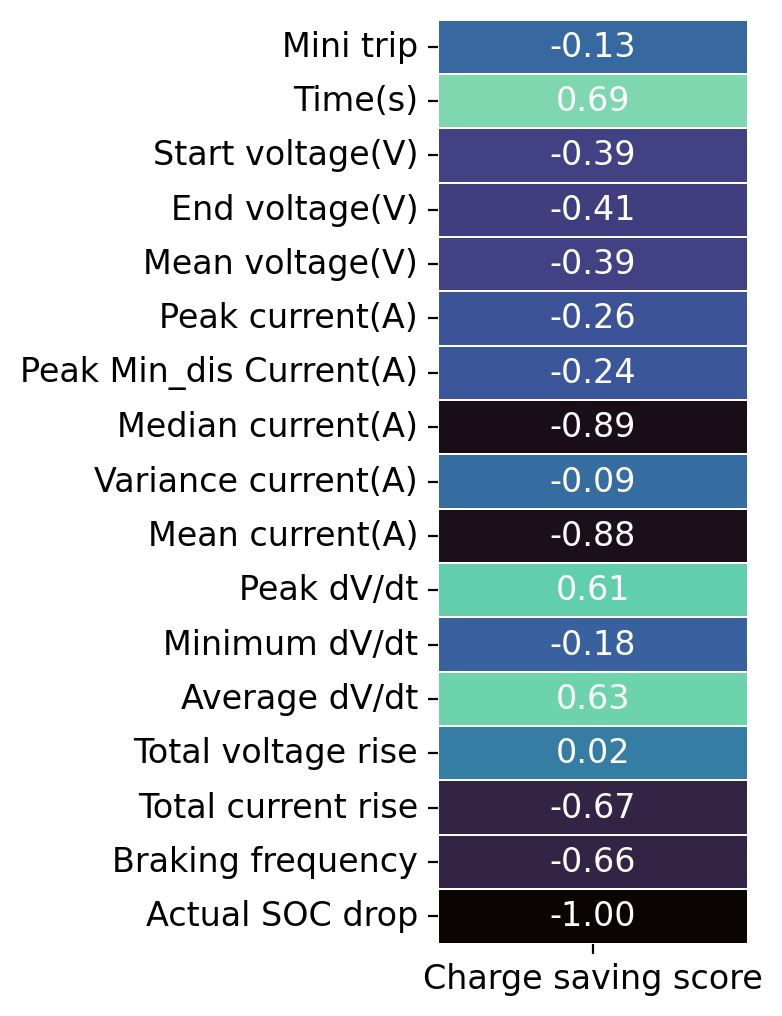

In [3]:
%run {FORECAST_DATA_NB}

##### Training data

In [4]:
rel_soc_array

[-0.13229649408555544,
 -0.2976534474760185,
 -0.6283966251697222,
 -0.9591572357125927,
 -1.28986870146,
 -1.6206225461921293]

In [5]:
train_class_path = MISC_DIR / 'Classification_features_train.txt'

classification_train = pd.DataFrame(
    np.loadtxt(train_class_path, delimiter=',', skiprows=1),
    columns=[
        'Defensive driving style',
        'Assertive driving style',
        'Downhill terrain',
        'Flat plane terrain',
        'Uphill terrain',
        'Charge & no rest (a)',
        'No charge & no rest (b)',
        'No charge & no rest (c)',
        'No charge & no rest (d)',
        'Charge & rest (a)',
        'Charge & rest (b)',
        'Charge & rest (c)',
        'Cell ID (a)',
        'Cell ID (b)',
        'Cell ID (c)'
    ]
)

In [6]:
cut_dict_350 = {}
data_list_350 = []

for key in dict.keys():
    datafr_350 = cut_time(dict[key], 300, 350)
    data_list_350.append(datafr_350)

cut_dict_350 = {f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_350)}
cut_data_350 = features_ext(cut_dict_350)
cut_data_350['Charge Usage score 350'] = cut_data_350['SOC_drop (%)']/rel_soc_array[0]
cut_data_350 = cut_data_350.drop(columns='Relative_SOC_drop', axis =1)

cut_data_350_with_classification = pd.concat(
    [cut_data_350.reset_index(drop=True), classification_train.reset_index(drop=True)],
    axis=1)

cut_data_350_with_classification

Mini Trip  Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  40.0021          3.853367        3.840435         3.847643   
1           2  34.5564          3.825440        3.828958         3.826971   
2           3  36.0347          3.836214        3.820742         3.821352   
3           4  32.9814          3.797720        3.808939         3.804083   
4           5  42.4806          3.796045        3.789937         3.792646   
..        ...      ...               ...             ...              ...   
91         92  43.5120          3.755281        3.766108         3.760713   
92         93  39.1444          3.740973        3.727139         3.731356   
93         94  40.9557          3.703782        3.619632         3.692257   
94         95  43.4347          3.688385        3.706670         3.711750   
95         96  47.3598          3.601665        3.665031         3.635364   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.315498                -0.358489          -0.333096   
1         -0.332344                -0.355217          -0.332639   
2         -0.247821                -0.306373          -0.298523   
3         -0.296925                -0.345615          -0.306589   
4         -0.295346                -0.321400          -0.314471   
..              ...                      ...                ...   
91        -0.286446                -0.450002          -0.320795   
92        -0.334714                -0.368091          -0.357475   
93        -0.199769                -0.513600          -0.267631   
94        -0.161506                -0.293228          -0.220985   
95        -0.298848                -0.491922          -0.372065   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.000304        -0.334778  ...                   1.0   
1              0.000084        -0.336478  ...                   0.0   
2              0.000357        -0.291893  ...                   0.0   
3              0.000308        -0.310870  ...                   0.0   
4              0.000098        -0.312283  ...                   1.0   
..                  ...              ...  ...                   ...   
91             0.004907        -0.349008  ...                   0.0   
92             0.000142        -0.354350  ...                   1.0   
93             0.013640        -0.313340  ...                   0.0   
94             0.001869        -0.224417  ...                   0.0   
95             0.003684        -0.392815  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       0.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
91                      0.0                      0.0                      1.0   
92                      0.0                      0.0                      0.0   
93                      1.0                      0.0                      0.0   
94                      0.0                      1.0                      0.0   
95                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0          1.0   
1                 1.0                0.0                0.0          1.0   
2                 0.0                1.0                0.0          1.0   
3                 0.0                0.0                1.0          1.0   
4                 0.0                0.0                0.0         

In [7]:
cut_dict_400 = {}
data_list_400 = []

for key in dict.keys():
    datafr_400 = cut_time(dict[key], 300, 400)
    data_list_400.append(datafr_400)

cut_dict_400 = {f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_400)}
cut_data_400 = features_ext(cut_dict_400)
cut_data_400['Charge Usage score 400'] = cut_data_400['SOC_drop (%)']/rel_soc_array[1]
cut_data_400 = cut_data_400.drop(columns= ['Relative_SOC_drop', 'Charge Usage score 350'], axis =1)

cut_data_400_with_classification = pd.concat(
    [cut_data_400.reset_index(drop=True), classification_train.reset_index(drop=True)],
    axis=1)

cut_data_400_with_classification

Mini Trip  Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  92.3408          3.853367        3.845118         3.843591   
1           2  84.5587          3.825440        3.827247         3.827539   
2           3  88.2715          3.836214        3.848385         3.826832   
3           4  87.7146          3.797720        3.812878         3.806539   
4           5  92.4835          3.796045        3.795833         3.793357   
..        ...      ...               ...             ...              ...   
91         92  90.3563          3.755281        3.768725         3.765908   
92         93  89.1474          3.740973        3.739816         3.732803   
93         94  86.3346          3.703782        3.688422         3.639565   
94         95  91.9329          3.688385        3.685338         3.699056   
95         96  89.4531          3.601665        3.679882         3.665915   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.315498                -0.371565          -0.335647   
1         -0.332344                -0.355217          -0.332749   
2         -0.195192                -0.310548          -0.296038   
3         -0.278081                -0.345615          -0.289021   
4         -0.291863                -0.329984          -0.307145   
..              ...                      ...                ...   
91        -0.149262                -0.450002          -0.286446   
92        -0.322103                -0.368091          -0.354461   
93        -0.199769                -0.818060          -0.469704   
94        -0.161506                -0.328556          -0.276060   
95        -0.135462                -0.491922          -0.254205   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.000248        -0.338904  ...                   1.0   
1              0.000045        -0.335135  ...                   0.0   
2              0.001442        -0.274166  ...                   0.0   
3              0.000277        -0.296097  ...                   0.0   
4              0.000182        -0.307670  ...                   1.0   
..                  ...              ...  ...                   ...   
91             0.008132        -0.288566  ...                   0.0   
92             0.000243        -0.348178  ...                   1.0   
93             0.034333        -0.489068  ...                   0.0   
94             0.002671        -0.260739  ...                   0.0   
95             0.011072        -0.298039  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       0.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
91                      0.0                      0.0                      1.0   
92                      0.0                      0.0                      0.0   
93                      1.0                      0.0                      0.0   
94                      0.0                      1.0                      0.0   
95                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0          1.0   
1                 1.0                0.0                0.0          1.0   
2                 0.0                1.0                0.0          1.0   
3                 0.0                0.0                1.0          1.0   
4                 0.0                0.0                0.0         

In [8]:
cut_dict_500 = {}
data_list_500 = []

for key in dict.keys():
    datafr_500 = cut_time(dict[key], 300, 500)
    data_list_500.append(datafr_500)

cut_dict_500 = {f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_500)}
cut_data_500 = features_ext(cut_dict_500)
cut_data_500['Charge Usage score 500'] = cut_data_500['SOC_drop (%)']/rel_soc_array[2]
cut_data_500 = cut_data_500.drop(columns=['Relative_SOC_drop', 'Charge Usage score 350',  'Charge Usage score 400'], axis =1)

cut_data_500_with_classification = pd.concat(
    [cut_data_500.reset_index(drop=True), classification_train.reset_index(drop=True)],
    axis=1)

cut_data_500_with_classification

Mini Trip   Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  191.4182          3.853367        3.859400         3.851436   
1           2  188.9158          3.825440        3.833646         3.831384   
2           3  192.8358          3.836214        3.827756         3.831369   
3           4  184.4134          3.797720        3.812928         3.805397   
4           5  191.7214          3.796045        3.800097         3.797440   
..        ...       ...               ...             ...              ...   
91         92  194.9879          3.755281        3.758526         3.762640   
92         93  190.3109          3.740973        3.726331         3.740686   
93         94  186.0979          3.703782        3.684448         3.655199   
94         95  192.4436          3.688385        3.690798         3.696031   
95         96  197.5933          3.601665        3.641446         3.647694   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.160354                -0.371565          -0.321711   
1         -0.182461                -0.355217          -0.332548   
2         -0.178817                -0.310548          -0.254481   
3         -0.223990                -0.368736          -0.292896   
4         -0.168034                -0.329984          -0.290221   
..              ...                      ...                ...   
91        -0.149262                -0.450002          -0.322412   
92        -0.268022                -0.368091          -0.322060   
93        -0.199769                -0.818060          -0.357832   
94        -0.161506                -0.328556          -0.274427   
95        -0.135462                -0.530723          -0.357498   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.002868        -0.303686  ...                   1.0   
1              0.001739        -0.310836  ...                   0.0   
2              0.001627        -0.255255  ...                   0.0   
3              0.001080        -0.298884  ...                   0.0   
4              0.001440        -0.282558  ...                   1.0   
..                  ...              ...  ...                   ...   
91             0.005370        -0.310086  ...                   0.0   
92             0.001256        -0.315200  ...                   1.0   
93             0.026050        -0.443002  ...                   0.0   
94             0.001666        -0.265674  ...                   0.0   
95             0.009342        -0.348079  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       0.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
91                      0.0                      0.0                      1.0   
92                      0.0                      0.0                      0.0   
93                      1.0                      0.0                      0.0   
94                      0.0                      1.0                      0.0   
95                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0          1.0   
1                 1.0                0.0                0.0          1.0   
2                 0.0                1.0                0.0          1.0   
3                 0.0                0.0                1.0          1.0   
4                 0.0                0.0                

In [9]:
cut_dict_600 = {}
data_list_600 = []

for key in dict.keys():
    datafr_600 = cut_time(dict[key], 300, 600)
    data_list_600.append(datafr_600)

cut_dict_600 = {f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_600)}
cut_data_600 = features_ext(cut_dict_600)
cut_data_600['Charge Usage score 600'] = cut_data_600['SOC_drop (%)']/rel_soc_array[3]
cut_data_600 = cut_data_600.drop(columns=['Relative_SOC_drop', 'Charge Usage score 350',  'Charge Usage score 400', 'Charge Usage score 500'], axis =1)

cut_data_600_with_classification = pd.concat(
    [cut_data_600.reset_index(drop=True), classification_train.reset_index(drop=True)],
    axis=1)

cut_data_600_with_classification

Mini Trip   Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  293.1234          3.853367        3.899720         3.859448   
1           2  288.3840          3.825440        3.811513         3.828187   
2           3  293.6487          3.836214        3.807981         3.826373   
3           4  285.9081          3.797720        3.785812         3.795784   
4           5  290.2106          3.796045        3.837159         3.801260   
..        ...       ...               ...             ...              ...   
91         92  293.0209          3.755281        3.755457         3.762700   
92         93  284.6601          3.740973        3.740031         3.735164   
93         94  285.4527          3.703782        3.695551         3.661586   
94         95  289.3263          3.688385        3.734435         3.683663   
95         96  291.0920          3.601665        3.642384         3.659137   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.107182                -0.371565          -0.284360   
1         -0.182461                -0.371942          -0.332749   
2         -0.178817                -0.327917          -0.277916   
3         -0.223990                -0.537201          -0.304644   
4         -0.115632                -0.329984          -0.285279   
..              ...                      ...                ...   
91        -0.123577                -0.450002          -0.322134   
92        -0.268022                -0.414481          -0.328420   
93        -0.199769                -0.818060          -0.357532   
94        -0.133978                -0.533918          -0.280362   
95        -0.097804                -0.530723          -0.345946   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.006136        -0.268384  ...                   1.0   
1              0.001591        -0.319587  ...                   0.0   
2              0.001599        -0.269765  ...                   0.0   
3              0.005078        -0.330124  ...                   0.0   
4              0.002909        -0.261864  ...                   1.0   
..                  ...              ...  ...                   ...   
91             0.005503        -0.294549  ...                   0.0   
92             0.001639        -0.325549  ...                   1.0   
93             0.021512        -0.421733  ...                   0.0   
94             0.008451        -0.298243  ...                   0.0   
95             0.011508        -0.307994  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       0.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
91                      0.0                      0.0                      1.0   
92                      0.0                      0.0                      0.0   
93                      1.0                      0.0                      0.0   
94                      0.0                      1.0                      0.0   
95                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0          1.0   
1                 1.0                0.0                0.0          1.0   
2                 0.0                1.0                0.0          1.0   
3                 0.0                0.0                1.0          1.0   
4                 0.0                0.0                

In [10]:
cut_dict_700 = {}
data_list_700 = []

for key in dict.keys():
    datafr_700 = cut_time(dict[key], 300, 700)
    data_list_700.append(datafr_700)

cut_dict_700 = {f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_700)}
cut_data_700 = features_ext(cut_dict_700)
cut_data_700['Charge Usage score 700'] = cut_data_700['SOC_drop (%)']/rel_soc_array[4]
cut_data_700 = cut_data_700.drop(columns=['Relative_SOC_drop', 'Charge Usage score 350',  'Charge Usage score 400', 'Charge Usage score 500', 'Charge Usage score 600'], axis =1)

cut_data_700_with_classification = pd.concat(
    [cut_data_700.reset_index(drop=True), classification_train.reset_index(drop=True)],
    axis=1)

cut_data_700_with_classification

Mini Trip   Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  392.9196          3.853367        3.840640         3.868323   
1           2  388.5218          3.825440        3.812049         3.823998   
2           3  393.6515          3.836214        3.808740         3.821859   
3           4  385.7115          3.797720        3.804272         3.795513   
4           5  396.9701          3.796045        3.775873         3.807767   
..        ...       ...               ...             ...              ...   
91         92  393.0268          3.755281        3.752217         3.761028   
92         93  384.1347          3.740973        3.713910         3.723049   
93         94  384.0611          3.703782        3.703224         3.667576   
94         95  390.4401          3.688385        3.667846         3.683335   
95         96  397.2916          3.601665        3.637331         3.655419   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.029862                -0.371565          -0.260011   
1         -0.182461                -0.379497          -0.336712   
2         -0.178817                -0.359104          -0.295083   
3         -0.223990                -0.537201          -0.304644   
4         -0.024798                -0.344341          -0.268869   
..              ...                      ...                ...   
91        -0.123577                -0.450002          -0.322412   
92        -0.268022                -0.568212          -0.341083   
93        -0.199769                -0.818060          -0.357464   
94        -0.107694                -0.533918          -0.292543   
95        -0.097804                -0.530723          -0.352160   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.009878        -0.233038  ...                   1.0   
1              0.001504        -0.329174  ...                   0.0   
2              0.002110        -0.284028  ...                   0.0   
3              0.004378        -0.324938  ...                   0.0   
4              0.007846        -0.233715  ...                   1.0   
..                  ...              ...  ...                   ...   
91             0.004523        -0.298485  ...                   0.0   
92             0.005499        -0.350610  ...                   1.0   
93             0.020241        -0.401155  ...                   0.0   
94             0.008123        -0.296319  ...                   0.0   
95             0.009762        -0.316140  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       0.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
91                      0.0                      0.0                      1.0   
92                      0.0                      0.0                      0.0   
93                      1.0                      0.0                      0.0   
94                      0.0                      1.0                      0.0   
95                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0          1.0   
1                 1.0                0.0                0.0          1.0   
2                 0.0                1.0                0.0          1.0   
3                 0.0                0.0                1.0          1.0   
4                 0.0                0.0                

In [11]:
cut_dict_800 = {}
data_list_800 = []

for key in dict.keys():
    datafr_800 = cut_time(dict[key], 300, 800)
    data_list_800.append(datafr_800)

cut_dict_800 = {f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_800)}
cut_data_800 = features_ext(cut_dict_800)
cut_data_800['Charge Usage score 800'] = cut_data_800['SOC_drop (%)']/rel_soc_array[5]
cut_data_800 = cut_data_800.drop(columns=['Relative_SOC_drop', 'Charge Usage score 350',  'Charge Usage score 400', 'Charge Usage score 500', 'Charge Usage score 600', 'Charge Usage score 700'], axis =1)

cut_data_800_with_classification = pd.concat(
    [cut_data_800.reset_index(drop=True), classification_train.reset_index(drop=True)],
    axis=1)

cut_data_800_with_classification

Mini Trip   Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  498.2785          3.853367        3.846318         3.861675   
1           2  482.1791          3.825440        3.809607         3.821051   
2           3  494.4990          3.836214        3.813374         3.819919   
3           4  489.5848          3.797720        3.769630         3.795607   
4           5  496.6855          3.796045        3.792684         3.802303   
..        ...       ...               ...             ...              ...   
91         92  496.5359          3.755281        3.754886         3.760149   
92         93  487.6598          3.740973        3.717616         3.723380   
93         94  491.2119          3.703782        3.698575         3.677905   
94         95  484.1548          3.688385        3.656023         3.678666   
95         96  497.8600          3.601665        3.651608         3.657131   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.029862                -0.371565          -0.290050   
1         -0.182461                -0.379497          -0.339989   
2         -0.178817                -0.359104          -0.295083   
3         -0.223990                -0.537201          -0.301091   
4         -0.024798                -0.385378          -0.280622   
..              ...                      ...                ...   
91        -0.123577                -0.450002          -0.294712   
92        -0.218840                -0.568212          -0.332925   
93        -0.166904                -0.818060          -0.357337   
94        -0.107694                -0.533918          -0.298938   
95        -0.097804                -0.530723          -0.304893   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.009414        -0.253142  ...                   1.0   
1              0.001335        -0.334662  ...                   0.0   
2              0.001730        -0.286618  ...                   0.0   
3              0.003937        -0.320272  ...                   0.0   
4              0.007163        -0.248240  ...                   1.0   
..                  ...              ...  ...                   ...   
91             0.004241        -0.292415  ...                   0.0   
92             0.005091        -0.342327  ...                   1.0   
93             0.021922        -0.365208  ...                   0.0   
94             0.007495        -0.307075  ...                   0.0   
95             0.008849        -0.306705  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       0.0                      0.0                      0.0   
2                       0.0                      0.0                      0.0   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
91                      0.0                      0.0                      1.0   
92                      0.0                      0.0                      0.0   
93                      1.0                      0.0                      0.0   
94                      0.0                      1.0                      0.0   
95                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0          1.0   
1                 1.0                0.0                0.0          1.0   
2                 0.0                1.0                0.0          1.0   
3                 0.0                0.0                1.0          1.0   
4                 0.0                0.0                

In [12]:
print(cut_data_350_with_classification['SOC_drop (%)'])
print(cut_data_400_with_classification['SOC_drop (%)'])
print(cut_data_500_with_classification['SOC_drop (%)'])
print(cut_data_600_with_classification['SOC_drop (%)'])
print(cut_data_700_with_classification['SOC_drop (%)'])
print(cut_data_800_with_classification['SOC_drop (%)'])

0    -0.125784
1    -0.106497
2    -0.099909
3    -0.092394
4    -0.121169
        ...   
91   -0.134525
92   -0.129575
93   -0.093126
94   -0.081837
95   -0.156825
Name: SOC_drop (%), Length: 96, dtype: float64
0    -0.292466
1    -0.260913
2    -0.220473
3    -0.236982
4    -0.260628
        ...   
91   -0.228402
92   -0.287349
93   -0.278883
94   -0.218638
95   -0.241344
Name: SOC_drop (%), Length: 96, dtype: float64
0    -0.554184
1    -0.555183
2    -0.443613
3    -0.506081
4    -0.502381
        ...   
91   -0.547961
92   -0.560942
93   -0.609085
94   -0.467110
95   -0.611981
Name: SOC_drop (%), Length: 96, dtype: float64
0    -0.750157
1    -0.869357
2    -0.724684
3    -0.830975
4    -0.691426
        ...   
91   -0.785161
92   -0.866461
93   -0.932019
94   -0.722576
95   -0.846804
Name: SOC_drop (%), Length: 96, dtype: float64
0    -0.873508
1    -1.203167
2    -1.039187
3    -1.111688
4    -0.827553
        ...   
91   -1.073215
92   -1.183439
93   -1.200368
94   -1.020374
95

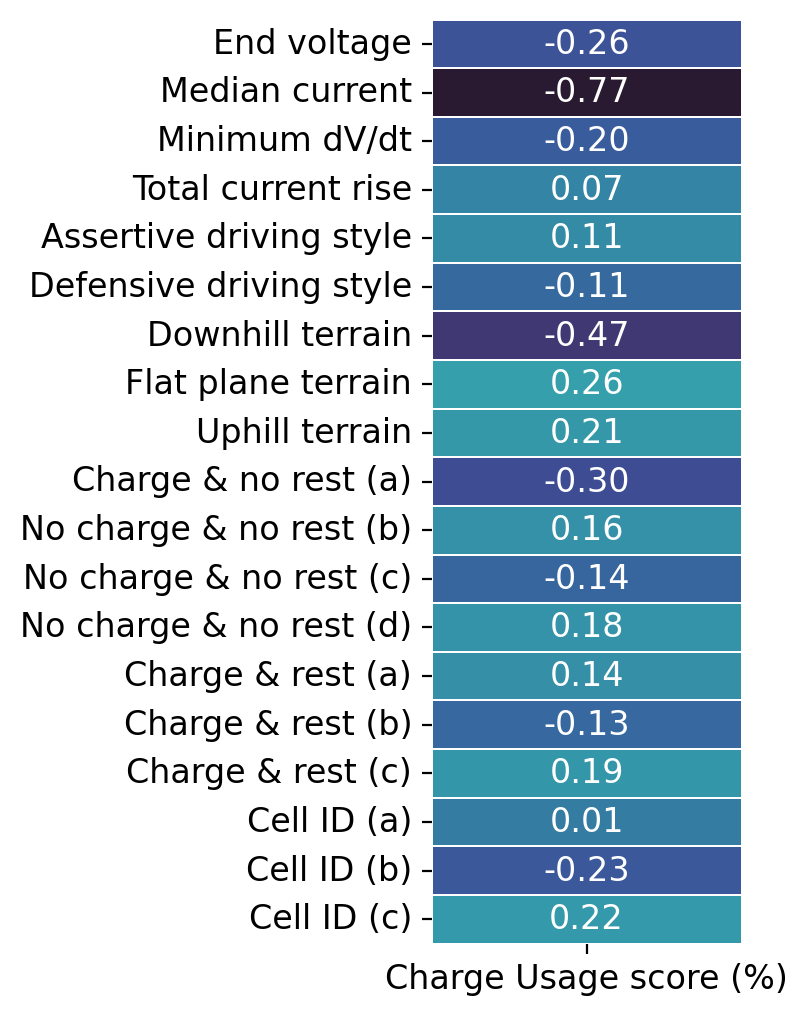

In [13]:
corr_matrix = cut_data_800_with_classification.corr()
target_corr = corr_matrix[["Charge Usage score 800"]].drop(["Charge Usage score 800"])
target_corr_renamed = target_corr.rename(columns={"Charge Usage score 800": "Charge Usage score (%)"})
feature_name_mapping = {
    'End Voltage(V)': 'End voltage',
    'Median Current(A)': 'Median current',
    'Min dV/dt': 'Minimum dV/dt',
    'Total Current Rise': 'Total current rise'
}

features_selected = ['End voltage', 'Median current', 'Minimum dV/dt', 'Total current rise', 'Assertive driving style',
       'Defensive driving style', 'Downhill terrain', 'Flat plane terrain',
       'Uphill terrain', 'Charge & no rest (a)', 'No charge & no rest (b)',
       'No charge & no rest (c)', 'No charge & no rest (d)',
       'Charge & rest (a)', 'Charge & rest (b)', 'Charge & rest (c)',
       'Cell ID (a)', 'Cell ID (b)', 'Cell ID (c)']

target_corr_renamed = target_corr_renamed.rename(index=feature_name_mapping)
features_selected_renamed = [feature_name_mapping.get(feature, feature) for feature in features_selected]
target_corr_filtered = target_corr_renamed.loc[features_selected_renamed]



plt.figure(figsize=(2, 6))
sns.heatmap(
    target_corr_filtered,
    annot=True,
    cmap="mako",
    fmt=".2f",
    vmin=-1,
    vmax=1,
    linewidths=0.01,
    annot_kws={"color": "white"},  
    cbar_kws={"label": "Correlation Coefficient"} , cbar = False
)

# plt.gcf().savefig('/Users/hemanthnr/Desktop/correlation_currentmodels.svg', format='svg', dpi=2000, bbox_inches='tight')
plt.show()

#### combined training data (features)

In [14]:
X_train = cut_data_350_with_classification.drop("Charge Usage score 350", axis=1)
X_train = X_train[['End Voltage(V)', 'Median Current(A)', 'Min dV/dt', 'Total Current Rise', 'Assertive driving style',
        'Defensive driving style',
        'Downhill terrain', 
        'Flat plane terrain', 
        'Uphill terrain',
        'Charge & no rest (a)',
        'No charge & no rest (b)',
        'No charge & no rest (c)',
        'No charge & no rest (d)',
        'Charge & rest (a)',
        'Charge & rest (b)',
        'Charge & rest (c)',
        'Cell ID (a)',
        'Cell ID (b)',
        'Cell ID (c)']]

#### combined training data (target)

In [15]:
y_train_350 = cut_data_350_with_classification["Charge Usage score 350"]
y_train_400 = cut_data_400_with_classification["Charge Usage score 400"]
y_train_500 = cut_data_500_with_classification["Charge Usage score 500"]
y_train_600 = cut_data_600_with_classification["Charge Usage score 600"]
y_train_700 = cut_data_700_with_classification["Charge Usage score 700"]
y_train_800 = cut_data_800_with_classification["Charge Usage score 800"]

Y_train = 100 * pd.DataFrame({
    "Charge Usage score 350": y_train_350,
    "Charge Usage score 400": y_train_400,
    "Charge Usage score 500": y_train_500,
    "Charge Usage score 600": y_train_600,
    "Charge Usage score 700": y_train_700,
    "Charge Usage score 800": y_train_800,
})

## Tetsing data

In [16]:
classification_test_path = MISC_DIR / 'Classification_features_test.txt'

classification_test = pd.DataFrame(
    np.loadtxt(classification_test_path, delimiter=',', skiprows=1),
    columns=['Defensive driving style',
        'Assertive driving style',
        'Downhill terrain', 
        'Flat plane terrain', 
        'Uphill terrain',
        'Charge & no rest (a)',
        'No charge & no rest (b)',
        'No charge & no rest (c)',
        'No charge & no rest (d)',
        'Charge & rest (a)',
        'Charge & rest (b)',
        'Charge & rest (c)',
        'Cell ID (a)',
        'Cell ID (b)',
        'Cell ID (c)'
    ]
)

In [17]:
cut_dict_test_300_350={}
data_list_test_300_350=[]
for key in dict_test.keys():
    datafr_350_test = cut_time(dict_test[key], 300, 350)  ##Function to select the time limit till what we want to cut down the data to
    data_list_test_300_350.append(datafr_350_test)
cut_dict_test_300_350={f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_test_300_350)}

cut_data_350_test = features_ext_test(cut_dict_test_300_350)
cut_data_350_test['Charge saving score 350'] = cut_data_350_test['SOC_drop (%)']/rel_soc_array[0]
cut_data_350_test = cut_data_350_test.drop(columns='Relative_SOC_drop', axis =1)

cut_data_350_test = pd.concat(
    [cut_data_350_test.reset_index(drop=True), classification_test.reset_index(drop=True)],
    axis=1)

cut_data_350_test[:14]

Mini Trip  Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  40.0092          3.839883        3.841950         3.842150   
1           2  40.0057          3.818634        3.809680         3.814415   
2           3  40.0099          3.842140        3.843057         3.842680   
3           4  40.0078          3.815004        3.808755         3.811939   
4           5  47.9190          3.657783        3.685990         3.667313   
5           6  38.0133          3.677652        3.643440         3.661131   
6           7  40.0027          3.806461        3.818501         3.813766   
7           8  40.0014          3.769205        3.766803         3.768266   
8           9  40.0029          3.844823        3.857441         3.852352   
9          10  40.0030          3.806447        3.804986         3.806025   
10         11  47.5955          3.761253        3.839254         3.802743   
11         12  40.0045          3.696546        3.692918         3.695306   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.380581                -0.423015          -0.393884   
1         -0.304332                -0.378248          -0.340619   
2         -0.324208                -0.396313          -0.335324   
3         -0.298760                -0.331595          -0.319680   
4         -0.342216                -0.439259          -0.387445   
5         -0.303039                -0.372706          -0.337080   
6         -0.093350                -0.252420          -0.142985   
7         -0.333085                -0.340822          -0.336564   
8         -0.101638                -0.254720          -0.154136   
9         -0.296117                -0.306126          -0.299727   
10        -0.082044                -0.254273          -0.157818   
11        -0.332772                -0.341270          -0.335874   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.000280        -0.397788  ...                   1.0   
1              0.000860        -0.340886  ...                   0.0   
2              0.001003        -0.352009  ...                   0.0   
3              0.000184        -0.319446  ...                   0.0   
4              0.000764        -0.391859  ...                   1.0   
5              0.000770        -0.337614  ...                   0.0   
6              0.003801        -0.155560  ...                   0.0   
7              0.000010        -0.336079  ...                   0.0   
8              0.003537        -0.164706  ...                   1.0   
9              0.000014        -0.300638  ...                   0.0   
10             0.003370        -0.161041  ...                   0.0   
11             0.000013        -0.337136  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       1.0                      0.0                      0.0   
2                       0.0                      1.0                      0.0   
3                       0.0                      0.0                      1.0   
4                       0.0                      0.0                      0.0   
5                       1.0                      0.0                      0.0   
6                       0.0                      1.0                      0.0   
7                       0.0                      0.0                      1.0   
8                       0.0                      0.0                      0.0   
9                       1.0                      0.0                      0.0   
10                      0.0                      1.0                      0.0   
11                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0          1.0   


In [18]:
cut_dict_test_400={}
data_list_test_400=[]
for key in dict_test.keys():
    datafr_400_test = cut_time(dict_test[key], 300, 400)  ##Function to select the time limit till what we want to cut down the data to
    data_list_test_400.append(datafr_400_test)
cut_dict_test_400 ={f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_test_400)}

cut_data_400_test = features_ext_test(cut_dict_test_400)
cut_data_400_test['Charge saving score 400'] = cut_data_400_test['SOC_drop (%)']/rel_soc_array[1]
cut_data_400_test = cut_data_400_test.drop(columns= ['Relative_SOC_drop', 'Charge saving score 350'], axis =1)
cut_data_400_test = pd.concat(
    [cut_data_400_test.reset_index(drop=True), classification_test.reset_index(drop=True)],
    axis=1)

cut_data_400_test

Mini Trip  Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  96.2584          3.839883        3.841490         3.845351   
1           2  90.0153          3.818634        3.818428         3.814615   
2           3  98.9596          3.842140        3.840350         3.844586   
3           4  90.0148          3.815004        3.816894         3.812615   
4           5  97.4985          3.657783        3.667599         3.693211   
5           6  92.7804          3.677652        3.704055         3.667550   
6           7  87.9650          3.806461        3.796920         3.810247   
7           8  90.0043          3.769205        3.768905         3.768095   
8           9  92.2170          3.844823        3.836556         3.849807   
9          10  90.0050          3.806447        3.805844         3.805814   
10         11  94.5289          3.761253        3.718742         3.786386   
11         12  90.0068          3.696546        3.707828         3.698263   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.200052                -0.423015          -0.380581   
1         -0.236678                -0.378248          -0.323537   
2         -0.182106                -0.396313          -0.328787   
3         -0.228073                -0.343797          -0.307219   
4         -0.192294                -0.439259          -0.343269   
5         -0.233915                -0.391770          -0.324633   
6         -0.071189                -0.324862          -0.183861   
7         -0.300115                -0.340822          -0.333078   
8         -0.078986                -0.326652          -0.186706   
9         -0.273539                -0.306126          -0.296742   
10        -0.061082                -0.337472          -0.193938   
11        -0.300833                -0.341270          -0.332784   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.004362        -0.351456  ...                   1.0   
1              0.002058        -0.316299  ...                   0.0   
2              0.003551        -0.314302  ...                   0.0   
3              0.001543        -0.297694  ...                   0.0   
4              0.005166        -0.328925  ...                   1.0   
5              0.002169        -0.321149  ...                   0.0   
6              0.007680        -0.192319  ...                   0.0   
7              0.000210        -0.326442  ...                   0.0   
8              0.007079        -0.191742  ...                   1.0   
9              0.000131        -0.292713  ...                   0.0   
10             0.006402        -0.194854  ...                   0.0   
11             0.000211        -0.327209  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       1.0                      0.0                      0.0   
2                       0.0                      1.0                      0.0   
3                       0.0                      0.0                      1.0   
4                       0.0                      0.0                      0.0   
5                       1.0                      0.0                      0.0   
6                       0.0                      1.0                      0.0   
7                       0.0                      0.0                      1.0   
8                       0.0                      0.0                      0.0   
9                       1.0                      0.0                      0.0   
10                      0.0                      1.0                      0.0   
11                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0          1.0   


In [19]:
cut_dict_test_500={}
data_list_test_500=[]
for key in dict_test.keys():
    datafr_500_test = cut_time(dict_test[key], 300, 500)  ##Function to select the time limit till what we want to cut down the data to
    data_list_test_500.append(datafr_500_test)
cut_dict_test_500 ={f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_test_500)}

cut_data_500_test = features_ext_test(cut_dict_test_500)
cut_data_500_test['Charge saving score 500'] = cut_data_500_test['SOC_drop (%)']/rel_soc_array[2]
cut_data_500_test = cut_data_500_test.drop(columns=['Relative_SOC_drop', 'Charge saving score 350',  'Charge saving score 400'], axis =1)
cut_data_500_test = pd.concat(
    [cut_data_500_test.reset_index(drop=True), classification_test.reset_index(drop=True)],
    axis=1)
cut_data_500_test

Mini Trip   Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  196.2757          3.839883        3.841633         3.843406   
1           2  189.4530          3.818634        3.801280         3.811349   
2           3  198.9719          3.842140        3.839731         3.842513   
3           4  192.8664          3.815004        3.804117         3.810954   
4           5  197.5124          3.657783        3.686723         3.688387   
5           6  191.1517          3.677652        3.645135         3.656578   
6           7  192.1078          3.806461        3.785449         3.797595   
7           8  195.1151          3.769205        3.765807         3.764831   
8           9  190.2029          3.844823        3.827984         3.839347   
9          10  197.9742          3.806447        3.802969         3.802177   
10         11  197.7696          3.761253        3.710072         3.726560   
11         12  193.9999          3.696546        3.699931         3.685779   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.200052                -0.423015          -0.357013   
1         -0.218235                -0.490156          -0.304332   
2         -0.182106                -0.396313          -0.306167   
3         -0.207504                -0.420739          -0.285790   
4         -0.192294                -0.439259          -0.343573   
5         -0.215370                -0.505642          -0.334874   
6         -0.071189                -0.521229          -0.355594   
7         -0.294194                -0.434737          -0.336830   
8         -0.078986                -0.483710          -0.326652   
9         -0.256823                -0.379907          -0.299727   
10        -0.061082                -0.580699          -0.356902   
11        -0.295094                -0.437701          -0.341270   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.002383        -0.350530  ...                   1.0   
1              0.004701        -0.318612  ...                   0.0   
2              0.001977        -0.310739  ...                   0.0   
3              0.002828        -0.291518  ...                   0.0   
4              0.003729        -0.335485  ...                   1.0   
5              0.006146        -0.342005  ...                   0.0   
6              0.015362        -0.295677  ...                   0.0   
7              0.001142        -0.342935  ...                   0.0   
8              0.012540        -0.273482  ...                   1.0   
9              0.000969        -0.306890  ...                   0.0   
10             0.020569        -0.326087  ...                   0.0   
11             0.001254        -0.349245  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       1.0                      0.0                      0.0   
2                       0.0                      1.0                      0.0   
3                       0.0                      0.0                      1.0   
4                       0.0                      0.0                      0.0   
5                       1.0                      0.0                      0.0   
6                       0.0                      1.0                      0.0   
7                       0.0                      0.0                      1.0   
8                       0.0                      0.0                      0.0   
9                       1.0                      0.0                      0.0   
10                      0.0                      1.0                      0.0   
11                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0    

In [20]:
cut_dict_test_600={}
data_list_test_600=[]
for key in dict_test.keys():
    datafr_600_test = cut_time(dict_test[key], 300, 600)  ##Function to select the time limit till what we want to cut down the data to
    data_list_test_600.append(datafr_600_test)
cut_dict_test_600 ={f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_test_600)}

cut_data_600_test = features_ext_test(cut_dict_test_600)
cut_data_600_test['Charge saving score 600'] = cut_data_600_test['SOC_drop (%)']/rel_soc_array[3]
cut_data_600_test = cut_data_600_test.drop(columns=['Relative_SOC_drop', 'Charge saving score 350',  'Charge saving score 400', 'Charge saving score 500'], axis =1)
cut_data_600_test = pd.concat(
    [cut_data_600_test.reset_index(drop=True), classification_test.reset_index(drop=True)],
    axis=1)
cut_data_600_test

Mini Trip   Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  296.2875          3.839883        3.840515         3.842765   
1           2  289.4733          3.818634        3.802793         3.807581   
2           3  298.9897          3.842140        3.837298         3.841301   
3           4  292.8793          3.815004        3.807806         3.808744   
4           5  297.5272          3.657783        3.700524         3.689819   
5           6  295.2034          3.677652        3.691086         3.657109   
6           7  292.1119          3.806461        3.780556         3.792810   
7           8  295.1204          3.769205        3.762745         3.765299   
8           9  297.9937          3.844823        3.833319         3.833675   
9          10  297.9786          3.806447        3.796494         3.801905   
10         11  297.2628          3.761253        3.741150         3.723533   
11         12  292.7283          3.696546        3.697807         3.694594   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.200052                -0.423015          -0.332862   
1         -0.218235                -0.490156          -0.337440   
2         -0.182106                -0.396313          -0.293858   
3         -0.207504                -0.420739          -0.297902   
4         -0.192294                -0.439259          -0.326632   
5         -0.215370                -0.505642          -0.337642   
6         -0.071189                -0.521229          -0.356999   
7         -0.225322                -0.434737          -0.332301   
8         -0.078986                -0.483710          -0.329161   
9         -0.218674                -0.379907          -0.293611   
10        -0.061082                -0.580699          -0.356940   
11        -0.236338                -0.437701          -0.331653   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.002182        -0.334653  ...                   1.0   
1              0.003431        -0.325278  ...                   0.0   
2              0.001626        -0.299168  ...                   0.0   
3              0.002043        -0.293164  ...                   0.0   
4              0.003068        -0.327367  ...                   1.0   
5              0.004780        -0.338524  ...                   0.0   
6              0.011093        -0.315480  ...                   0.0   
7              0.002063        -0.320696  ...                   0.0   
8              0.010027        -0.295539  ...                   1.0   
9              0.001409        -0.290654  ...                   0.0   
10             0.016131        -0.329692  ...                   0.0   
11             0.002293        -0.324526  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       1.0                      0.0                      0.0   
2                       0.0                      1.0                      0.0   
3                       0.0                      0.0                      1.0   
4                       0.0                      0.0                      0.0   
5                       1.0                      0.0                      0.0   
6                       0.0                      1.0                      0.0   
7                       0.0                      0.0                      1.0   
8                       0.0                      0.0                      0.0   
9                       1.0                      0.0                      0.0   
10                      0.0                      1.0                      0.0   
11                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0    

In [21]:
cut_dict_test_700={}
data_list_test_700=[]
for key in dict_test.keys():
    datafr_700_test = cut_time(dict_test[key], 300, 700)  ##Function to select the time limit till what we want to cut down the data to
    data_list_test_700.append(datafr_700_test)
cut_dict_test_700 ={f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_test_700)}

cut_data_700_test = features_ext_test(cut_dict_test_700)
cut_data_700_test['Charge saving score 700'] = cut_data_700_test['SOC_drop (%)']/rel_soc_array[4]
cut_data_700_test = cut_data_700_test.drop(columns=['Relative_SOC_drop', 'Charge saving score 350',  'Charge saving score 400', 'Charge saving score 500', 'Charge saving score 600'], axis =1)
cut_data_700_test = pd.concat(
    [cut_data_700_test.reset_index(drop=True), classification_test.reset_index(drop=True)],
    axis=1)
cut_data_700_test

Mini Trip   Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  396.3020          3.839883        3.833367         3.841794   
1           2  389.4931          3.818634        3.796253         3.805413   
2           3  399.0053          3.842140        3.830186         3.839758   
3           4  392.8983          3.815004        3.801585         3.807375   
4           5  389.9322          3.657783        3.678390         3.691283   
5           6  395.9699          3.677652        3.668287         3.660585   
6           7  392.1162          3.806461        3.781788         3.789627   
7           8  395.1253          3.769205        3.758938         3.764240   
8           9  392.0212          3.844823        3.823030         3.831049   
9          10  397.9853          3.806447        3.793912         3.800449   
10         11  390.2935          3.761253        3.725551         3.721179   
11         12  392.7402          3.696546        3.688985         3.694608   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.200052                -0.423015          -0.319776   
1         -0.218235                -0.490156          -0.298171   
2         -0.182106                -0.396313          -0.289984   
3         -0.207504                -0.420739          -0.283216   
4         -0.192294                -0.439259          -0.315975   
5         -0.215370                -0.505642          -0.319577   
6         -0.071189                -0.521229          -0.357062   
7         -0.225322                -0.434737          -0.311273   
8         -0.078986                -0.483710          -0.321415   
9         -0.218674                -0.379907          -0.284686   
10        -0.061082                -0.580699          -0.356901   
11        -0.236338                -0.437701          -0.312392   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.002167        -0.323798  ...                   1.0   
1              0.002870        -0.316989  ...                   0.0   
2              0.001455        -0.292433  ...                   0.0   
3              0.001704        -0.287501  ...                   0.0   
4              0.002827        -0.319395  ...                   1.0   
5              0.004367        -0.328174  ...                   0.0   
6              0.008622        -0.320960  ...                   0.0   
7              0.001596        -0.317165  ...                   0.0   
8              0.007750        -0.295923  ...                   1.0   
9              0.001076        -0.288427  ...                   0.0   
10             0.012904        -0.330768  ...                   0.0   
11             0.001883        -0.320998  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       1.0                      0.0                      0.0   
2                       0.0                      1.0                      0.0   
3                       0.0                      0.0                      1.0   
4                       0.0                      0.0                      0.0   
5                       1.0                      0.0                      0.0   
6                       0.0                      1.0                      0.0   
7                       0.0                      0.0                      1.0   
8                       0.0                      0.0                      0.0   
9                       1.0                      0.0                      0.0   
10                      0.0                      1.0                      0.0   
11                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0    

In [22]:
cut_dict_test_800={}
data_list_test_800=[]
for key in dict_test.keys():
    datafr_800_test = cut_time(dict_test[key], 300, 800)  ##Function to select the time limit till what we want to cut down the data to
    data_list_test_800.append(datafr_800_test)
cut_dict_test_800 ={f'Minitrip{i+1}': dataf for i, dataf in enumerate(data_list_test_800)}

cut_data_800_test = features_ext_test(cut_dict_test_800)
cut_data_800_test['Charge saving score 800'] = cut_data_800_test['SOC_drop (%)']/rel_soc_array[5]
cut_data_800_test = cut_data_800_test.drop(columns=['Relative_SOC_drop', 'Charge saving score 350',  'Charge saving score 400', 'Charge saving score 500', 'Charge saving score 600', 'Charge saving score 700'], axis =1)
cut_data_800_test = pd.concat(
    [cut_data_800_test.reset_index(drop=True), classification_test.reset_index(drop=True)],
    axis=1)
cut_data_800_test

Mini Trip   Time(s)  Start Voltage(V)  End Voltage(V)  Mean Voltage(V)  \
0           1  496.3182          3.839883        3.827207         3.839476   
1           2  489.5139          3.818634        3.792275         3.803153   
2           3  499.0203          3.842140        3.824928         3.837296   
3           4  492.9169          3.815004        3.798272         3.805815   
4           5  489.9454          3.657783        3.668404         3.688104   
5           6  495.9903          3.677652        3.666859         3.661507   
6           7  490.3326          3.806461        3.776230         3.786902   
7           8  495.1343          3.769205        3.754430         3.762642   
8           9  490.9904          3.844823        3.816317         3.828192   
9          10  497.9896          3.806447        3.789376         3.798655   
10         11  498.2701          3.761253        3.707735         3.714174   
11         12  492.7495          3.696546        3.675818         3.692480   

    Peak Current(A)  Peak Min_dis Current(A)  Median Current(A)  \
0         -0.200052                -0.423015          -0.333291   
1         -0.218235                -0.490156          -0.297593   
2         -0.182106                -0.396313          -0.296864   
3         -0.207504                -0.420739          -0.276024   
4         -0.192294                -0.439259          -0.327447   
5         -0.215370                -0.505642          -0.297886   
6         -0.071189                -0.521229          -0.357062   
7         -0.225322                -0.434737          -0.318058   
8         -0.078986                -0.483710          -0.319165   
9         -0.218674                -0.379907          -0.288652   
10        -0.061082                -0.580699          -0.356961   
11        -0.236338                -0.437701          -0.319538   

    Variance Current(A)  Mean Current(A)  ...  Charge & no rest (a)  \
0              0.001768        -0.326580  ...                   1.0   
1              0.002365        -0.312928  ...                   0.0   
2              0.001177        -0.294091  ...                   0.0   
3              0.001395        -0.284778  ...                   0.0   
4              0.002411        -0.322343  ...                   1.0   
5              0.003869        -0.323654  ...                   0.0   
6              0.007316        -0.324077  ...                   0.0   
7              0.001305        -0.319327  ...                   0.0   
8              0.006916        -0.297216  ...                   1.0   
9              0.000871        -0.289711  ...                   0.0   
10             0.011131        -0.340295  ...                   0.0   
11             0.001576        -0.322040  ...                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       1.0                      0.0                      0.0   
2                       0.0                      1.0                      0.0   
3                       0.0                      0.0                      1.0   
4                       0.0                      0.0                      0.0   
5                       1.0                      0.0                      0.0   
6                       0.0                      1.0                      0.0   
7                       0.0                      0.0                      1.0   
8                       0.0                      0.0                      0.0   
9                       1.0                      0.0                      0.0   
10                      0.0                      1.0                      0.0   
11                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0    

### combined testing data (features)

In [23]:
X_test = cut_data_350_test.drop("Charge saving score 350", axis=1)
X_test = X_test[['End Voltage(V)', 'Median Current(A)', 'Min dV/dt', 'Total Current Rise', 'Assertive driving style',
        'Defensive driving style',
        'Downhill terrain', 
        'Flat plane terrain', 
        'Uphill terrain',
        'Charge & no rest (a)',
        'No charge & no rest (b)',
        'No charge & no rest (c)',
        'No charge & no rest (d)',
        'Charge & rest (a)',
        'Charge & rest (b)',
        'Charge & rest (c)',
        'Cell ID (a)',
        'Cell ID (b)',
        'Cell ID (c)']]

### combined testing data (target)

In [24]:
y_test_350 = cut_data_350_test["Charge saving score 350"]
y_test_400 = cut_data_400_test["Charge saving score 400"]
y_test_500 = cut_data_500_test["Charge saving score 500"]
y_test_600 = cut_data_600_test["Charge saving score 600"]
y_test_700 = cut_data_700_test["Charge saving score 700"]
y_test_800 = cut_data_800_test["Charge saving score 800"]

Y_test = 100 * pd.DataFrame({
    "Charge saving score 350": y_test_350,
    "Charge saving score 400": y_test_400,
    "Charge saving score 500": y_test_500,
    "Charge saving score 600": y_test_600,
    "Charge saving score 700": y_test_700,
    "Charge saving score 800": y_test_800,
})

## Random Forest regression model

In [25]:
def rf_trainer(X, Y, X_test, Y_test, iterations=10):
    y_pred_train_list = []
    y_true_train_list = []
    mae_train_list = []
    mape_train_list = []
    y_pred_val_list = [] 
    y_true_val_list = []
    mae_val_list = []
    mape_val_list = []
    mae_test_list = []
    mape_test_list = []
    y_pred_test_list = [] 
    y_true_test_list = []
    
    skf = KFold(n_splits=5, random_state=42, shuffle=True)
    for i in range(iterations):
        print(f"--- Iteration {i+1}/{iterations} ---")

        x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
        model = RandomForestRegressor()
        param_grid = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth': np.arange(2, 10)}
        model_search = GridSearchCV(estimator=model,
                                    param_grid=param_grid,
                                    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                                    cv=skf,
                                    refit='neg_mean_absolute_error',
                                    verbose=3,
                                    return_train_score=True)
        
        model_search.fit(x_train, y_train)
        best_model = model_search.best_estimator_
        
        # Training set predictions and metrics
        y_pred_train = best_model.predict(x_train)
        y_true_train_list.append(y_train)
        y_pred_train_list.append(y_pred_train)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
        mae_train_list.append(mae_train)
        mape_train_list.append(mape_train)
        
        # Validation set predictions and metrics
        y_pred_val = best_model.predict(x_val)
        y_true_val_list.append(y_val)
        y_pred_val_list.append(y_pred_val)
        mae_val = mean_absolute_error(y_val, y_pred_val)
        mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
        mae_val_list.append(mae_val)
        mape_val_list.append(mape_val)
        
        # Test set predictions and metrics
        y_pred_test = best_model.predict(X_test)
        y_true_test_list.append(Y_test)
        y_pred_test_list.append(y_pred_test)
        mae_test = mean_absolute_error(Y_test, y_pred_test)
        mape_test = mean_absolute_percentage_error(Y_test, y_pred_test)
        mae_test_list.append(mae_test)
        mape_test_list.append(mape_test)
        
        print(f"Iteration {i+1} Results:")
        print(f"Validation MAE: {mae_val}, MAPE: {mape_val}")
        print(f"Test MAE: {mae_test}, MAPE: {mape_test}")
    
    # Calculate averages
    mae_train_avg = np.mean(mae_train_list)
    mape_train_avg = np.mean(mape_train_list)
    mae_val_avg = np.mean(mae_val_list)
    mape_val_avg = np.mean(mape_val_list)
    mae_test_avg = np.mean(mae_test_list)
    mape_test_avg = np.mean(mape_test_list)
    
    print("\n--- Final Results Across All Iterations ---")
    print(f"Average Train MAE: {mae_train_avg}")
    print(f"Average Train MAPE: {mape_train_avg}")
    print(f"Average Validation MAE: {mae_val_avg}")
    print(f"Average Validation MAPE: {mape_val_avg}")
    print(f"Average Test MAE: {mae_test_avg}")
    print(f"Average Test MAPE: {mape_test_avg}")
    
    return (y_pred_train_list, y_true_train_list, mae_train_list, mape_train_list, 
            y_pred_val_list, y_true_val_list, mae_val_list, mape_val_list,  
            y_pred_test_list, y_true_test_list, mae_test_list, mape_test_list, mae_train_avg, 
            mape_train_avg,mae_val_avg, mape_val_avg, mae_test_avg, mape_test_avg)

#### Results for 350 seconds

In [ ]:
y_pred_train_list_350, y_true_train_list_350, mae_train_list_350, mape_train_list_350, y_pred_val_list_350, y_true_val_list_350, mae_val_list_350, mape_val_list_350, y_pred_test_list_350, y_true_test_list_350, mae_test_list_350, mape_test_list_350, mae_train_avg_350, mape_train_avg_350, mae_val_avg_350, mape_val_avg_350, mae_test_avg_350, mape_test_avg_350 = rf_trainer(X_train, Y_train["Charge Usage score 350"], X_test, Y_test["Charge saving score 350"])

In [ ]:
plt.scatter(np.mean(y_true_test_list_350, axis=0), np.mean(y_pred_test_list_350, axis=0))
plt.plot([0, 120], [0, 120])
plt.xlim(0, 120)
plt.ylim(0, 120)
plt.show()

In [ ]:
y_pred_train_list_400, y_true_train_list_400, mae_train_list_400, mape_train_list_400, y_pred_val_list_400, y_true_val_list_400, mae_val_list_400, mape_val_list_400, y_pred_test_list_400, y_true_test_list_400, mae_test_list_400, mape_test_list_400, mae_train_avg_400, mape_train_avg_400, mae_val_avg_400, mape_val_avg_400, mae_test_avg_400, mape_test_avg_400 =  rf_trainer(X_train, Y_train["Charge Usage score 400"], X_test, Y_test["Charge saving score 400"])

In [ ]:
plt.scatter(np.mean(y_true_test_list_400, axis=0), np.mean(y_pred_test_list_400, axis=0))
plt.plot([50, 120], [50, 120])
plt.xlim(50, 120)
plt.ylim(50, 120)
plt.show()

In [ ]:
y_pred_train_list_500, y_true_train_list_500, mae_train_list_500, mape_train_list_500, y_pred_val_list_500, y_true_val_list_500, mae_val_list_500, mape_val_list_500, y_pred_test_list_500, y_true_test_list_500, mae_test_list_500, mape_test_list_500, mae_train_avg_500, mape_train_avg_500, mae_val_avg_500, mape_val_avg_500, mae_test_avg_500, mape_test_avg_500 =  rf_trainer(X_train, Y_train["Charge Usage score 500"], X_test, Y_test["Charge saving score 500"])

In [ ]:
plt.scatter(np.mean(y_true_test_list_500, axis=0), np.mean(y_pred_test_list_500, axis=0), marker = '^', alpha=1, zorder =4)
# plt.scatter(np.mean(y_true_val_list_500, axis=0), np.mean(y_pred_val_list_500, axis=0), marker='o', alpha=0.5)
# plt.scatter(np.mean(y_true_train_list_500, axis=0), np.mean(y_pred_train_list_500, axis=0), marker= 's', alpha=0.5)
plt.plot([50, 120], [50, 120])
plt.xlim(50, 120)
plt.ylim(50, 120)
plt.show()

In [ ]:
y_pred_train_list_600, y_true_train_list_600, mae_train_list_600, mape_train_list_600, y_pred_val_list_600, y_true_val_list_600, mae_val_list_600, mape_val_list_600, y_pred_test_list_600, y_true_test_list_600, mae_test_list_600, mape_test_list_600, mae_train_avg_600, mape_train_avg_600, mae_val_avg_600, mape_val_avg_600, mae_test_avg_600, mape_test_avg_600 =  rf_trainer(X_train, Y_train["Charge Usage score 600"], X_test, Y_test["Charge saving score 600"])

In [ ]:
plt.scatter(np.mean(y_true_test_list_600, axis=0), np.mean(y_pred_test_list_600, axis=0), marker = '^', alpha=1)
# plt.scatter(np.mean(y_true_val_list_600, axis=0), np.mean(y_pred_val_list_600, axis=0), marker='o', alpha=0.5)
# plt.scatter(np.mean(y_true_train_list_600, axis=0), np.mean(y_pred_train_list_600, axis=0), marker= 's', alpha=0.5)
plt.plot([50, 120], [50, 120])
plt.xlim(50, 120)
plt.ylim(50, 120)
plt.show()

In [ ]:
y_pred_train_list_700, y_true_train_list_700, mae_train_list_700, mape_train_list_700, y_pred_val_list_700, y_true_val_list_700, mae_val_list_700, mape_val_list_700, y_pred_test_list_700, y_true_test_list_700, mae_test_list_700, mape_test_list_700, mae_train_avg_700, mape_train_avg_700, mae_val_avg_700, mape_val_avg_700, mae_test_avg_700, mape_test_avg_700 =  rf_trainer(X_train, Y_train["Charge Usage score 700"], X_test, Y_test["Charge saving score 700"])

In [ ]:
plt.scatter(np.mean(y_true_test_list_700, axis=0), np.mean(y_pred_test_list_700, axis=0), marker = '^', alpha=1)
plt.scatter(np.mean(y_true_val_list_700, axis=0), np.mean(y_pred_val_list_700, axis=0), marker='o', alpha=0.5)
plt.scatter(np.mean(y_true_train_list_700, axis=0), np.mean(y_pred_train_list_700, axis=0), marker= 's', alpha=0.5)
plt.plot([50, 120], [50, 120])
plt.xlim(50, 120)
plt.ylim(50, 120)
plt.show()

In [ ]:
y_pred_train_list_800, y_true_train_list_800, mae_train_list_800, mape_train_list_800, y_pred_val_list_800, y_true_val_list_800, mae_val_list_800, mape_val_list_800, y_pred_test_list_800, y_true_test_list_800, mae_test_list_800, mape_test_list_800, mae_train_avg_800, mape_train_avg_800, mae_val_avg_800, mape_val_avg_800, mae_test_avg_800, mape_test_avg_800 =  rf_trainer(X_train, Y_train["Charge Usage score 800"], X_test, Y_test["Charge saving score 800"])

In [ ]:
y_true_test_list_800

In [ ]:
np.mean(y_pred_test_list_800, axis=0).shape

In [ ]:
# plt.scatter(np.mean(y_true_test_list_800, axis=0), np.mean(y_pred_test_list_800, axis=0), marker = '^', alpha=1)
# plt.scatter(np.mean(y_true_val_list_800, axis=0), np.mean(y_pred_val_list_800, axis=0), marker='o', alpha=0.5)
plt.scatter(np.mean(y_true_train_list_800, axis=0), np.mean(y_pred_train_list_800, axis=0), marker= 's', alpha=0.5)
plt.plot([50, 120], [50, 120])
plt.xlim(50, 120)
plt.ylim(50, 120)
plt.show()

#### save results

In [ ]:
y_train_actual_dict = {
    '350': pd.DataFrame(y_true_train_list_350).iloc[:1],
    '400': pd.DataFrame(y_true_train_list_400).iloc[:1],
    '500': pd.DataFrame(y_true_train_list_500).iloc[:1],
    '600': pd.DataFrame(y_true_train_list_600).iloc[:1],
    '700': pd.DataFrame(y_true_train_list_700).iloc[:1],
    '800': pd.DataFrame(y_true_train_list_800).iloc[:1]
}

y_val_actual_dict = {
    '350': pd.DataFrame(y_true_val_list_350).iloc[:1],
    '400': pd.DataFrame(y_true_val_list_400).iloc[:1],
    '500': pd.DataFrame(y_true_val_list_500).iloc[:1],
    '600': pd.DataFrame(y_true_val_list_600).iloc[:1],
    '700': pd.DataFrame(y_true_val_list_700).iloc[:1],
    '800': pd.DataFrame(y_true_val_list_800).iloc[:1]
}

y_test_actual_dict = {
    '350': pd.DataFrame(y_true_test_list_350).iloc[:1],
    '400': pd.DataFrame(y_true_test_list_400).iloc[:1],
    '500': pd.DataFrame(y_true_test_list_500).iloc[:1],
    '600': pd.DataFrame(y_true_test_list_600).iloc[:1],
    '700': pd.DataFrame(y_true_test_list_700).iloc[:1],
    '800': pd.DataFrame(y_true_test_list_800).iloc[:1]
}

# Save training data to HDF5
train_hdf5_file_path = FORECAST_MODEL_RESULT_DIR / "y_train_actual.h5"
with pd.HDFStore(train_hdf5_file_path, mode='w') as hdf:
    for key, df in y_train_actual_dict.items():
        hdf.put(f"key_{key}", df)
print(f"Training data saved to {train_hdf5_file_path}")

# Save validation data to HDF5
val_hdf5_file_path = FORECAST_MODEL_RESULT_DIR / "y_val_actual.h5"
with pd.HDFStore(val_hdf5_file_path, mode='w') as hdf:
    for key, df in y_val_actual_dict.items():
        hdf.put(f"key_{key}", df)
print(f"Validation data saved to {val_hdf5_file_path}")

# Save test data to HDF5
test_hdf5_file_path = FORECAST_MODEL_RESULT_DIR / "y_test_actual.h5"
with pd.HDFStore(test_hdf5_file_path, mode='w') as hdf:
    for key, df in y_test_actual_dict.items():
        hdf.put(f"key_{key}", df)
print(f"Test data saved to {test_hdf5_file_path}")

In [ ]:
# Y-pred (training data)
y_train_prediction_dict = {
    '350': pd.DataFrame(y_pred_train_list_350),
    '400': pd.DataFrame(y_pred_train_list_400),
    '500': pd.DataFrame(y_pred_train_list_500),
    '600': pd.DataFrame(y_pred_train_list_600),
    '700': pd.DataFrame(y_pred_train_list_700),
    '800': pd.DataFrame(y_pred_train_list_800)
}

# Y-pred (validation data)
y_val_prediction_dict = {
    '350': pd.DataFrame(y_pred_val_list_350),
    '400': pd.DataFrame(y_pred_val_list_400),
    '500': pd.DataFrame(y_pred_val_list_500),
    '600': pd.DataFrame(y_pred_val_list_600),
    '700': pd.DataFrame(y_pred_val_list_700),
    '800': pd.DataFrame(y_pred_val_list_800)
}

# Y-pred (test data)
y_test_prediction_dict = {
    '350': pd.DataFrame(y_pred_test_list_350),
    '400': pd.DataFrame(y_pred_test_list_400),
    '500': pd.DataFrame(y_pred_test_list_500),
    '600': pd.DataFrame(y_pred_test_list_600),
    '700': pd.DataFrame(y_pred_test_list_700),
    '800': pd.DataFrame(y_pred_test_list_800)
}

# Save training prediction data to HDF5
train_prediction_hdf5_file_path = FORECAST_MODEL_RESULT_DIR / "y_train_prediction.h5"
with pd.HDFStore(train_prediction_hdf5_file_path, mode='w') as hdf:
    for key, df in y_train_prediction_dict.items():
        hdf.put(f"key_{key}", df)
print(f"Training prediction data saved to {train_prediction_hdf5_file_path}")

# Save validation prediction data to HDF5
val_prediction_hdf5_file_path = FORECAST_MODEL_RESULT_DIR / "y_val_prediction.h5"
with pd.HDFStore(val_prediction_hdf5_file_path, mode='w') as hdf:
    for key, df in y_val_prediction_dict.items():
        hdf.put(f"key_{key}", df)
print(f"Validation prediction data saved to {val_prediction_hdf5_file_path}")

# Save test prediction data to HDF5
test_prediction_hdf5_file_path = FORECAST_MODEL_RESULT_DIR / "y_test_prediction.h5"
with pd.HDFStore(test_prediction_hdf5_file_path, mode='w') as hdf:
    for key, df in y_test_prediction_dict.items():
        hdf.put(f"key_{key}", df)
print(f"Test prediction data saved to {test_prediction_hdf5_file_path}")

In [42]:
##Average MAE scores
avg_mae_results = pd.DataFrame({
    '350': [mae_train_avg_350, mae_val_avg_350, mae_test_avg_350],
    '400': [mae_train_avg_400, mae_val_avg_400, mae_test_avg_400],
    '500': [mae_train_avg_500, mae_val_avg_500, mae_test_avg_500],
    '600': [mae_train_avg_600, mae_val_avg_600, mae_test_avg_600],
    '700': [mae_train_avg_700, mae_val_avg_700, mae_test_avg_700],
    '800': [mae_train_avg_800, mae_val_avg_800, mae_test_avg_800]
}, index=['train', 'validation', 'test'])

##Average MAPE scores
avg_mape_results = pd.DataFrame({
    '350': [mape_train_avg_350, mape_val_avg_350, mape_test_avg_350],
    '400': [mape_train_avg_400, mape_val_avg_400, mape_test_avg_400],
    '500': [mape_train_avg_500, mape_val_avg_500, mape_test_avg_500],
    '600': [mape_train_avg_600, mape_val_avg_600, mape_test_avg_600],
    '700': [mape_train_avg_700, mape_val_avg_700, mape_test_avg_700],
    '800': [mape_train_avg_800, mape_val_avg_800, mape_test_avg_800]
}, index=['train', 'val', 'test'])

avg_mae_results.to_hdf(FORECAST_MODEL_RESULT_DIR/ "avg_mae_results.h5", key='avg_mae', mode='w')
avg_mape_results.to_hdf(FORECAST_MODEL_RESULT_DIR /"avg_mape_results.h5", key='avg_mape', mode='w')


## Plotting

#### parity plots

In [3]:
actual_train =pd.HDFStore(FORECAST_MODEL_RESULT_DIR / 'y_train_actual.h5', mode='r')
actual_val =pd.HDFStore(FORECAST_MODEL_RESULT_DIR/ 'y_val_actual.h5', mode='r')
actual_test =pd.HDFStore(FORECAST_MODEL_RESULT_DIR/ 'y_test_actual.h5', mode='r')  

In [4]:
predicted_train = pd.HDFStore(FORECAST_MODEL_RESULT_DIR /'y_train_prediction.h5', mode='r')
predicted_val = pd.HDFStore(FORECAST_MODEL_RESULT_DIR /'y_val_prediction.h5', mode='r')
predicted_test = pd.HDFStore(FORECAST_MODEL_RESULT_DIR /'y_test_prediction.h5', mode='r')

In [5]:
predicted_test['key_350']
predicted_test['key_400']
predicted_test['key_500']
predicted_test['key_600']
predicted_test['key_700']
predicted_test['key_800']

0          1          2          3          4          5   \
0  88.562068  88.829728  84.940951  81.632581  86.869613  89.747641   
1  88.657613  89.396750  84.768722  81.643346  86.491251  89.248717   
2  89.479895  89.159732  82.646624  82.261090  90.285208  88.543732   
3  88.294134  87.753584  82.925142  82.731460  87.828121  87.629172   
4  88.531373  89.752010  83.768617  82.064904  88.087546  89.004552   
5  87.533302  87.669819  85.656623  81.686393  86.571501  88.604313   
6  88.054910  88.919243  86.513517  81.467912  85.343088  90.169898   
7  88.635685  86.606525  83.824613  82.511195  89.245192  88.044589   
8  88.202256  88.080451  84.005841  82.331336  87.732325  88.049944   
9  88.387578  89.269502  83.494906  80.922797  87.384170  88.699225   

          6          7          8          9          10         11  
0  80.479927  86.565305  77.668316  84.579184  81.648824  89.043445  
1  80.855767  85.911092  77.553912  84.107492  81.574963  87.768807  
2  81.989380  85.585829  76.495218  83.412742  82.903814  87.505001  
3  80.489692  84.457419  78.357484  83.541162  81.410605  85.454672  
4  81.856057  86.327641  75.624925  83.913877  82.827870  87.879572  
5  80.688186  84.554509  77.912280  84.044474  81.341580  86.964503  
6  80.942357  85.316788  78.331965  84.670672  82.154990  87.692577  
7  81.024750  85.000844  78.986410  84.201812  82.054039  86.477402  
8  80.835653  84.907276  78.860109  84.160183  81.551426  86.923215  
9  80.139554  85.626143  77.947059  84.181174  81.417533  86.332527

In [6]:
y_train_prediction_avg_350 = np.mean(predicted_train['key_350'], axis=0)
y_train_prediction_avg_400 = np.mean(predicted_train['key_400'], axis=0)
y_train_prediction_avg_500 = np.mean(predicted_train['key_500'], axis=0)
y_train_prediction_avg_600 = np.mean(predicted_train['key_600'], axis=0)
y_train_prediction_avg_700 = np.mean(predicted_train['key_700'], axis=0)
y_train_prediction_avg_800 = np.mean(predicted_train['key_800'], axis=0)

In [7]:
y_val_prediction_avg_350 = np.mean(predicted_val['key_350'], axis=0)
y_val_prediction_avg_400 = np.mean(predicted_val['key_400'], axis=0)
y_val_prediction_avg_500 = np.mean(predicted_val['key_500'], axis=0)
y_val_prediction_avg_600 = np.mean(predicted_val['key_600'], axis=0)
y_val_prediction_avg_700 = np.mean(predicted_val['key_700'], axis=0)
y_val_prediction_avg_800 = np.mean(predicted_val['key_800'], axis=0)

In [8]:
y_test_prediction_avg_350 = np.mean(predicted_test['key_350'], axis=0)
y_test_prediction_avg_400 = np.mean(predicted_test['key_400'], axis=0)
y_test_prediction_avg_500 = np.mean(predicted_test['key_500'], axis=0)
y_test_prediction_avg_600 = np.mean(predicted_test['key_600'], axis=0)
y_test_prediction_avg_700 = np.mean(predicted_test['key_700'], axis=0)
y_test_prediction_avg_800 = np.mean(predicted_test['key_800'], axis=0)

In [9]:
keys = [350, 400, 500, 600, 700, 800]

true_train = {
    350: np.array(actual_train['key_350']).flatten(),
    400: np.array(actual_train['key_400']).flatten(),
    500: np.array(actual_train['key_500']).flatten(),
    600: np.array(actual_train['key_600']).flatten(),
    700: np.array(actual_train['key_700']).flatten(),
    800: np.array(actual_train['key_800']).flatten()
}

true_val = {
    350: np.array(actual_val['key_350']).flatten(),
    400: np.array(actual_val['key_400']).flatten(),
    500: np.array(actual_val['key_500']).flatten(),
    600: np.array(actual_val['key_600']).flatten(),
    700: np.array(actual_val['key_700']).flatten(),
    800: np.array(actual_val['key_800']).flatten()
}

true_test = {
    350: np.array(actual_test['key_350']).flatten(),
    400: np.array(actual_test['key_400']).flatten(),
    500: np.array(actual_test['key_500']).flatten(),
    600: np.array(actual_test['key_600']).flatten(),
    700: np.array(actual_test['key_700']).flatten(),
    800: np.array(actual_test['key_800']).flatten()
}

pred_train = {
    350: np.array(y_train_prediction_avg_350).flatten(),
    400: np.array(y_train_prediction_avg_400).flatten(),
    500: np.array(y_train_prediction_avg_500).flatten(),
    600: np.array(y_train_prediction_avg_600).flatten(),
    700: np.array(y_train_prediction_avg_700).flatten(),
    800: np.array(y_train_prediction_avg_800).flatten()
}

pred_val = {
    350: np.array(y_val_prediction_avg_350).flatten(),
    400: np.array(y_val_prediction_avg_400).flatten(),
    500: np.array(y_val_prediction_avg_500).flatten(),
    600: np.array(y_val_prediction_avg_600).flatten(),
    700: np.array(y_val_prediction_avg_700).flatten(),
    800: np.array(y_val_prediction_avg_800).flatten()
}

pred_test = {
    350: np.array(y_test_prediction_avg_350).flatten(),
    400: np.array(y_test_prediction_avg_400).flatten(),
    500: np.array(y_test_prediction_avg_500).flatten(),
    600: np.array(y_test_prediction_avg_600).flatten(),
    700: np.array(y_test_prediction_avg_700).flatten(),
    800: np.array(y_test_prediction_avg_800).flatten()
}


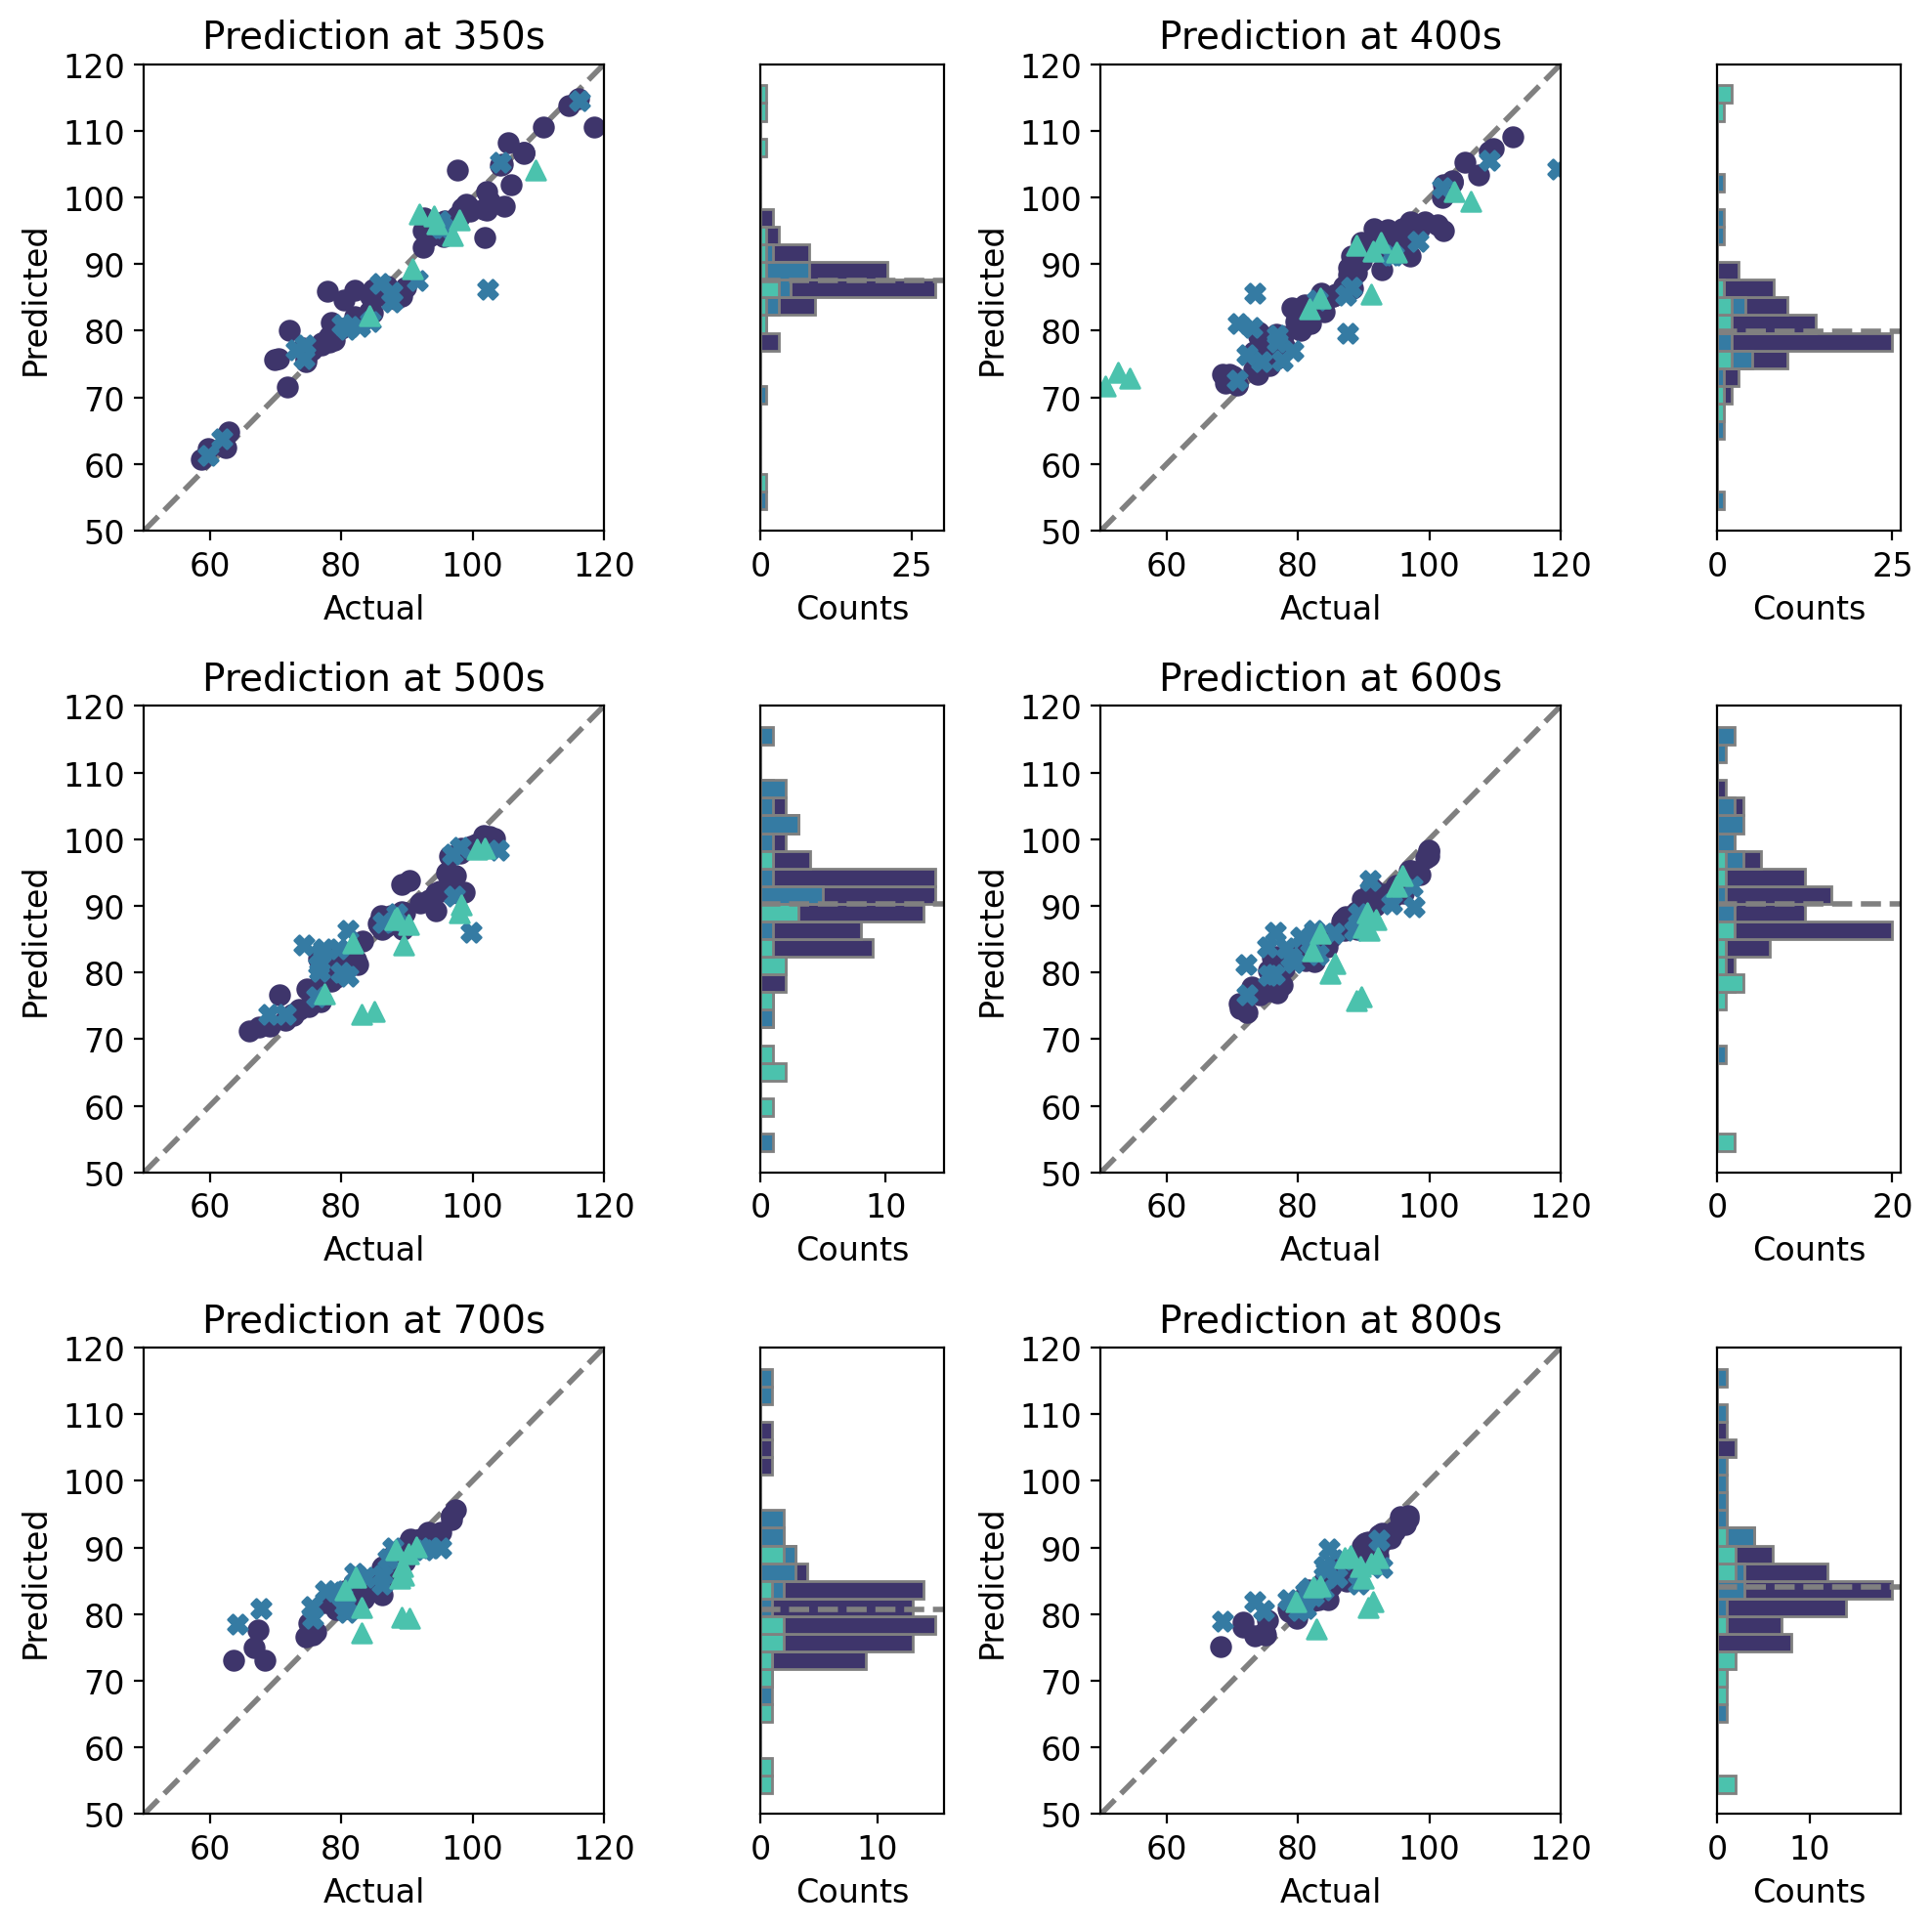

In [12]:
font_size = 12
sns.reset_orig()
plt.rcdefaults()
colors = sns.color_palette("mako", 3)
train_color, val_color, test_color = colors[0], colors[1], colors[2]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(3, 4, width_ratios=[5, 2] * 2, height_ratios=[1, 1, 1])

def plot_parity_and_hist(ax_parity, ax_hist, key):
    y_train = pred_train[key]
    y_val = pred_val[key]
    y_test = pred_test[key]
    actual_train_key = true_train[key]
    actual_val_key = true_val[key]
    actual_test_key = true_test[key]

    train_errors = y_train - actual_train_key
    val_errors = y_val - actual_val_key
    test_errors = y_test - actual_test_key

    all_errors = np.concatenate([train_errors, val_errors, test_errors])
    bins = np.linspace(np.min(all_errors), np.max(all_errors), 25)

    ax_parity.scatter(actual_train_key, y_train, color=train_color, s=50, label='Train', marker='o')
    ax_parity.scatter(actual_val_key, y_val, color=val_color, s=50, label='Validation', marker='X')
    ax_parity.scatter(actual_test_key, y_test, color=test_color, s=50, label='Test', marker='^')
    ax_parity.plot([50, 120], [50, 120], '--', lw=2, color="grey", zorder=0)
    ax_parity.set_xlim(50, 120)
    ax_parity.set_ylim(50, 120)
    ax_parity.set_xlabel('Actual', fontsize=font_size)
    ax_parity.set_ylabel('Predicted', fontsize=font_size)
    ax_parity.set_title(f'Prediction at {key}s', fontsize=font_size+2)
    ax_parity.tick_params(axis='both', which='major', labelsize=font_size)

    ax_hist.hist(train_errors, bins=bins, color=train_color, orientation='horizontal', ec = "grey")
    ax_hist.hist(val_errors, bins=bins, color=val_color, orientation='horizontal', ec = "grey")
    ax_hist.hist(test_errors, bins=bins, color=test_color, orientation='horizontal', ec = "grey")
    ax_hist.axhline(0, color='grey', linestyle='--', linewidth=2)
    ax_hist.set_xlabel('Counts', fontsize=font_size)
    ax_hist.yaxis.set_ticks([])
    ax_hist.tick_params(axis='x', which='major', labelsize=font_size)

for i, key in enumerate(keys):
    row, col = divmod(i, 2)
    ax_parity = plt.subplot(gs[row, col * 2])    
    ax_hist = plt.subplot(gs[row, col * 2 + 1]) 
    plot_parity_and_hist(ax_parity, ax_hist, key)

plt.tight_layout()
plt.show()

### Early predictions

In [33]:
sample_1 = pd.concat(
    [
        predicted_test['key_350'].iloc[:, 0],
        predicted_test['key_400'].iloc[:, 0],
        predicted_test['key_500'].iloc[:, 0],
        predicted_test['key_600'].iloc[:, 0],
        predicted_test['key_700'].iloc[:, 0],
        predicted_test['key_800'].iloc[:, 0],
    ],
    axis=1
)

sample_2 = pd.concat(
    [
        predicted_test['key_350'].iloc[:, 1],
        predicted_test['key_400'].iloc[:, 1],
        predicted_test['key_500'].iloc[:, 1],
        predicted_test['key_600'].iloc[:, 1],
        predicted_test['key_700'].iloc[:, 1],
        predicted_test['key_800'].iloc[:, 1],
    ],
    axis=1
)

sample_3 = pd.concat(
    [
        predicted_test['key_350'].iloc[:, 2],
        predicted_test['key_400'].iloc[:, 2],
        predicted_test['key_500'].iloc[:, 2],
        predicted_test['key_600'].iloc[:, 2],
        predicted_test['key_700'].iloc[:, 2],
        predicted_test['key_800'].iloc[:, 2],
    ],
    axis=1
)

sample_4 = pd.concat(
    [
        predicted_test['key_350'].iloc[:, 3],
        predicted_test['key_400'].iloc[:, 3],
        predicted_test['key_500'].iloc[:, 3],
        predicted_test['key_600'].iloc[:, 3],
        predicted_test['key_700'].iloc[:, 3],
        predicted_test['key_800'].iloc[:, 3],
    ],
    axis=1
)

sample_5 = pd.concat(
    [
        predicted_test['key_350'].iloc[:, 4],
        predicted_test['key_400'].iloc[:, 4],
        predicted_test['key_500'].iloc[:, 4],
        predicted_test['key_600'].iloc[:, 4],
        predicted_test['key_700'].iloc[:, 4],
        predicted_test['key_800'].iloc[:, 4],
    ],
    axis=1
)

sample_6 = pd.concat(
    [
        predicted_test['key_350'].iloc[:, 5],
        predicted_test['key_400'].iloc[:, 5],
        predicted_test['key_500'].iloc[:, 5],
        predicted_test['key_600'].iloc[:, 5],
        predicted_test['key_700'].iloc[:, 5],
        predicted_test['key_800'].iloc[:, 5],
    ],
    axis=1
)

sample_7 = pd.concat(
    [
        predicted_test['key_350'].iloc[:, 6],
        predicted_test['key_400'].iloc[:, 6],
        predicted_test['key_500'].iloc[:, 6],
        predicted_test['key_600'].iloc[:, 6],
        predicted_test['key_700'].iloc[:, 6],
        predicted_test['key_800'].iloc[:, 6],
    ],
    axis=1
)

sample_8 = pd.concat(
    [
        predicted_test['key_350'].iloc[:, 7],
        predicted_test['key_400'].iloc[:, 7],
        predicted_test['key_500'].iloc[:, 7],
        predicted_test['key_600'].iloc[:, 7],
        predicted_test['key_700'].iloc[:, 7],
        predicted_test['key_800'].iloc[:, 7],
    ],
    axis=1
)

sample_9 = pd.concat(
    [
        predicted_test['key_350'].iloc[:, 8],
        predicted_test['key_400'].iloc[:, 8],
        predicted_test['key_500'].iloc[:, 8],
        predicted_test['key_600'].iloc[:, 8],
        predicted_test['key_700'].iloc[:, 8],
        predicted_test['key_800'].iloc[:, 8],
    ],
    axis=1
)

sample_10 = pd.concat(
    [
        predicted_test['key_350'].iloc[:, 9],
        predicted_test['key_400'].iloc[:, 9],
        predicted_test['key_500'].iloc[:, 9],
        predicted_test['key_600'].iloc[:, 9],
        predicted_test['key_700'].iloc[:, 9],
        predicted_test['key_800'].iloc[:, 9],
    ],
    axis=1
)

sample_11 = pd.concat(
    [
        predicted_test['key_350'].iloc[:, 10],
        predicted_test['key_400'].iloc[:, 10],
        predicted_test['key_500'].iloc[:, 10],
        predicted_test['key_600'].iloc[:, 10],
        predicted_test['key_700'].iloc[:, 10],
        predicted_test['key_800'].iloc[:, 10],
    ],
    axis=1
)

sample_12 = pd.concat   ( [
        predicted_test['key_350'].iloc[:, 11],
        predicted_test['key_400'].iloc[:, 11],
        predicted_test['key_500'].iloc[:, 11],
        predicted_test['key_600'].iloc[:, 11],
        predicted_test['key_700'].iloc[:, 11],
        predicted_test['key_800'].iloc[:, 11],
    ],
    axis=1)

column_names = [
    'Charge saving score 350',
    'Charge saving score 400',
    'Charge saving score 500',
    'Charge saving score 600',
    'Charge saving score 700',
    'Charge saving score 800'
]

# Apply column names to each sample DataFrame
for sample in [sample_1, sample_2, sample_3, sample_4, sample_5, sample_6, sample_7, sample_8, sample_9, sample_10, sample_11, sample_12]:
    sample.columns = column_names

In [34]:
def calculate_confidence_interval(column, confidence=0.95):
    mean = column.mean()
    sem = stats.sem(column)
    margin = sem * stats.t.ppf((1 + confidence) / 2, len(column) - 1)
    return mean - margin, mean + margin

confidence_intervals_sample_1 = {col: calculate_confidence_interval(sample_1[col]) for col in sample_1.columns}
confidence_intervals_sample_2 = {col: calculate_confidence_interval(sample_2[col]) for col in sample_2.columns}
confidence_intervals_sample_3 = {col: calculate_confidence_interval(sample_3[col]) for col in sample_3.columns}
confidence_intervals_sample_4 = {col: calculate_confidence_interval(sample_4[col]) for col in sample_4.columns}
confidence_intervals_sample_5 = {col: calculate_confidence_interval(sample_5[col]) for col in sample_5.columns}
confidence_intervals_sample_6 = {col: calculate_confidence_interval(sample_6[col]) for col in sample_6.columns}
confidence_intervals_sample_7 = {col: calculate_confidence_interval(sample_7[col]) for col in sample_7.columns}
confidence_intervals_sample_8 = {col: calculate_confidence_interval(sample_8[col]) for col in sample_8.columns}
confidence_intervals_sample_9 = {col: calculate_confidence_interval(sample_9[col]) for col in sample_9.columns}
confidence_intervals_sample_10 = {col: calculate_confidence_interval(sample_10[col]) for col in sample_10.columns}
confidence_intervals_sample_11 = {col: calculate_confidence_interval(sample_11[col]) for col in sample_11.columns}
confidence_intervals_sample_12 = {col: calculate_confidence_interval(sample_12[col]) for col in sample_12.columns}

def plot_confidence_intervals(data, dataset_name):
    # Calculate confidence intervals
    confidence_intervals = {col: calculate_confidence_interval(data[col]) for col in data.columns}
    
    # Extract mean and confidence bounds
    means = [(ci[0] + ci[1]) / 2 for ci in confidence_intervals.values()]
    lower_bounds = [ci[0] for ci in confidence_intervals.values()]
    upper_bounds = [ci[1] for ci in confidence_intervals.values()]
    time_frames = [col.split()[-1] for col in data.columns]

    return means, lower_bounds, upper_bounds, time_frames

means_1, lb_1, ub_1, tf_1 = plot_confidence_intervals(sample_1, "Trip 1")
means_2, lb_2, ub_2, tf_2 = plot_confidence_intervals(sample_2, "Trip 2")
means_3, lb_3, ub_3, tf_3 = plot_confidence_intervals(sample_3, "Trip 3")
means_4, lb_4, ub_4, tf_4 = plot_confidence_intervals(sample_4, "Trip 4")
means_5, lb_5, ub_5, tf_5 = plot_confidence_intervals(sample_5, "Trip 5")
means_6, lb_6, ub_6, tf_6 = plot_confidence_intervals(sample_6, "Trip 6")
means_7, lb_7, ub_7, tf_7 = plot_confidence_intervals(sample_7, "Trip 7")
means_8, lb_8, ub_8, tf_8 = plot_confidence_intervals(sample_8, "Trip 8")
means_9, lb_9, ub_9, tf_9 = plot_confidence_intervals(sample_9, "Trip 9")
means_10, lb_10, ub_10, tf_10 = plot_confidence_intervals(sample_10, "Trip 10")
means_11, lb_11, ub_11, tf_11 = plot_confidence_intervals(sample_11, "Trip 11")
means_12, lb_12, ub_12, tf_12 = plot_confidence_intervals(sample_12, "Trip 12")

In [35]:
# Slice all means, lb, ub, and tf arrays
means_1 = means_1[2:6]
lb_1 = lb_1[2:6]
ub_1 = ub_1[2:6]
tf_1 = tf_1[2:6]

means_2 = means_2[2:6]
lb_2 = lb_2[2:6]
ub_2 = ub_2[2:6]
tf_2 = tf_2[2:6]

means_3 = means_3[2:6]
lb_3 = lb_3[2:6]
ub_3 = ub_3[2:6]
tf_3 = tf_3[2:6]

means_4 = means_4[2:6]
lb_4 = lb_4[2:6]
ub_4 = ub_4[2:6]
tf_4 = tf_4[2:6]

means_5 = means_5[2:6]
lb_5 = lb_5[2:6]
ub_5 = ub_5[2:6]
tf_5 = tf_5[2:6]

means_6 = means_6[2:6]
lb_6 = lb_6[2:6]
ub_6 = ub_6[2:6]
tf_6 = tf_6[2:6]

means_7 = means_7[2:6]
lb_7 = lb_7[2:6]
ub_7 = ub_7[2:6]
tf_7 = tf_7[2:6]

means_8 = means_8[2:6]
lb_8 = lb_8[2:6]
ub_8 = ub_8[2:6]
tf_8 = tf_8[2:6]

means_9 = means_9[2:6]
lb_9 = lb_9[2:6]
ub_9 = ub_9[2:6]
tf_9 = tf_9[2:6]

means_10 = means_10[2:6]
lb_10 = lb_10[2:6]
ub_10 = ub_10[2:6]
tf_10 = tf_10[2:6]

means_11 = means_11[2:6]
lb_11 = lb_11[2:6]
ub_11 = ub_11[2:6]
tf_11 = tf_11[2:6]

means_12 = means_12[2:6]
lb_12 = lb_12[2:6]
ub_12 = ub_12[2:6]
tf_12 = tf_12[2:6]

In [36]:
classification_test

Defensive driving style  Assertive driving style  Downhill terrain  \
0                       1.0                      0.0               0.0   
1                       0.0                      1.0               0.0   
2                       1.0                      0.0               1.0   
3                       0.0                      1.0               1.0   
4                       1.0                      0.0               0.0   
5                       0.0                      1.0               0.0   
6                       1.0                      0.0               0.0   
7                       0.0                      1.0               0.0   
8                       1.0                      0.0               1.0   
9                       0.0                      1.0               1.0   
10                      1.0                      0.0               0.0   
11                      0.0                      1.0               0.0   

    Flat plane terrain  Uphill terrain  Charge & no rest (a)  \
0                  0.0             1.0                   1.0   
1                  0.0             1.0                   0.0   
2                  0.0             0.0                   0.0   
3                  0.0             0.0                   0.0   
4                  1.0             0.0                   1.0   
5                  1.0             0.0                   0.0   
6                  0.0             1.0                   0.0   
7                  0.0             1.0                   0.0   
8                  0.0             0.0                   1.0   
9                  0.0             0.0                   0.0   
10                 1.0             0.0                   0.0   
11                 1.0             0.0                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       1.0                      0.0                      0.0   
2                       0.0                      1.0                      0.0   
3                       0.0                      0.0                      1.0   
4                       0.0                      0.0                      0.0   
5                       1.0                      0.0                      0.0   
6                       0.0                      1.0                      0.0   
7                       0.0                      0.0                      1.0   
8                       0.0                      0.0                      0.0   
9                       1.0                      0.0                      0.0   
10                      0.0                      1.0                      0.0   
11                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0          1.0   
1                 0.0                0.0                0.0          1.0   
2                 0.0                0.0                0.0          0.0   
3                 0.0                0.0                0.0          0.0   
4                 0.0                0.0                0.0          0.0   
5                 0.0                0.0                0.0          0.0   
6                 0.0                0.0                0.0          1.0   
7                 0.0                0.0                0.0          1.0   
8                 0.0                0.0                0.0          0.0   
9                 0.0                0.0                0.0          0.0   
10                0.0                0.0                0.0          0.0   
11                0.0                0.0                0.0          0.0   

    Cell ID (b)  Cell ID (c)  
0           0.0          0.0  
1           0.0          0.0  
2           1.0          0.0  
3           1.0          0.0  
4         

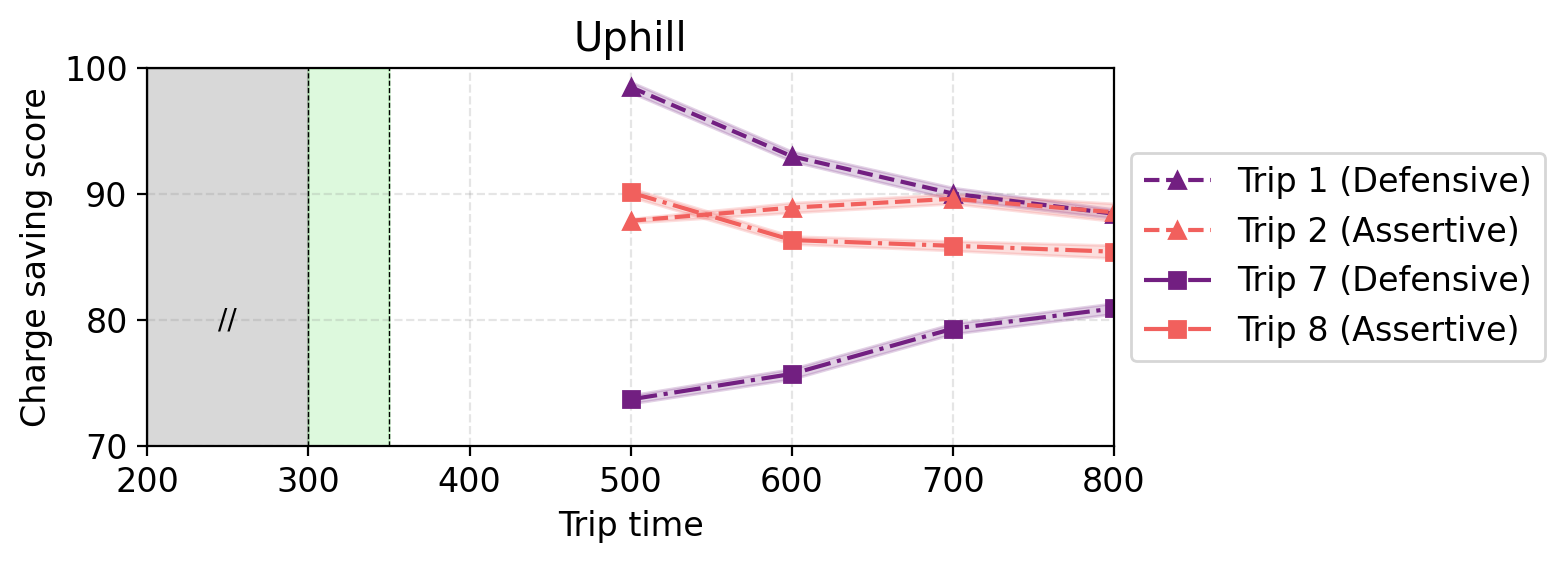

In [37]:
sns.reset_orig()
plt.rcdefaults()
plt.figure(figsize=(6, 3))
plt.rcParams['font.size'] = 12
colors = sns.color_palette("magma", 2)

time_frames = [500, 600, 700, 800]

plt.plot(time_frames, means_1, marker='^', label='Trip 1 (Defensive)', color=colors[0], linestyle="--")
plt.fill_between(time_frames, lb_1, ub_1, color=colors[0], alpha=0.2)
plt.plot(time_frames, means_2, marker='^', label='Trip 2 (Assertive)', color=colors[1], linestyle="--")
plt.fill_between(time_frames, lb_2, ub_2, color=colors[1], alpha=0.2)

plt.plot(time_frames, means_7, marker='s', label='Trip 7 (Defensive)', color=colors[0], linestyle="-.")
plt.fill_between(time_frames, lb_7, ub_7, color=colors[0], alpha=0.2)
plt.plot(time_frames, means_8, marker='s', label='Trip 8 (Assertive)', color=colors[1], linestyle="-.")
plt.fill_between(time_frames, lb_8, ub_8, color=colors[1], alpha=0.2)

plt.axvspan(200, 300, color='grey', alpha=0.3)
plt.axvspan(300, 350, color='lightgreen', alpha=0.3)
plt.axvline(300, color='black', linestyle='--', linewidth=0.5)
plt.axvline(350, color='black', linestyle='--', linewidth=0.5)
plt.grid(color="grey", alpha=0.2, linestyle="--")
plt.text(250, 80, "//", fontsize=10, va='center', ha='center', color='black')

plt.title('Uphill')
plt.xlabel('Trip time')
plt.ylabel('Charge saving score')
plt.ylim(70, 100)
plt.xlim(200, 800)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

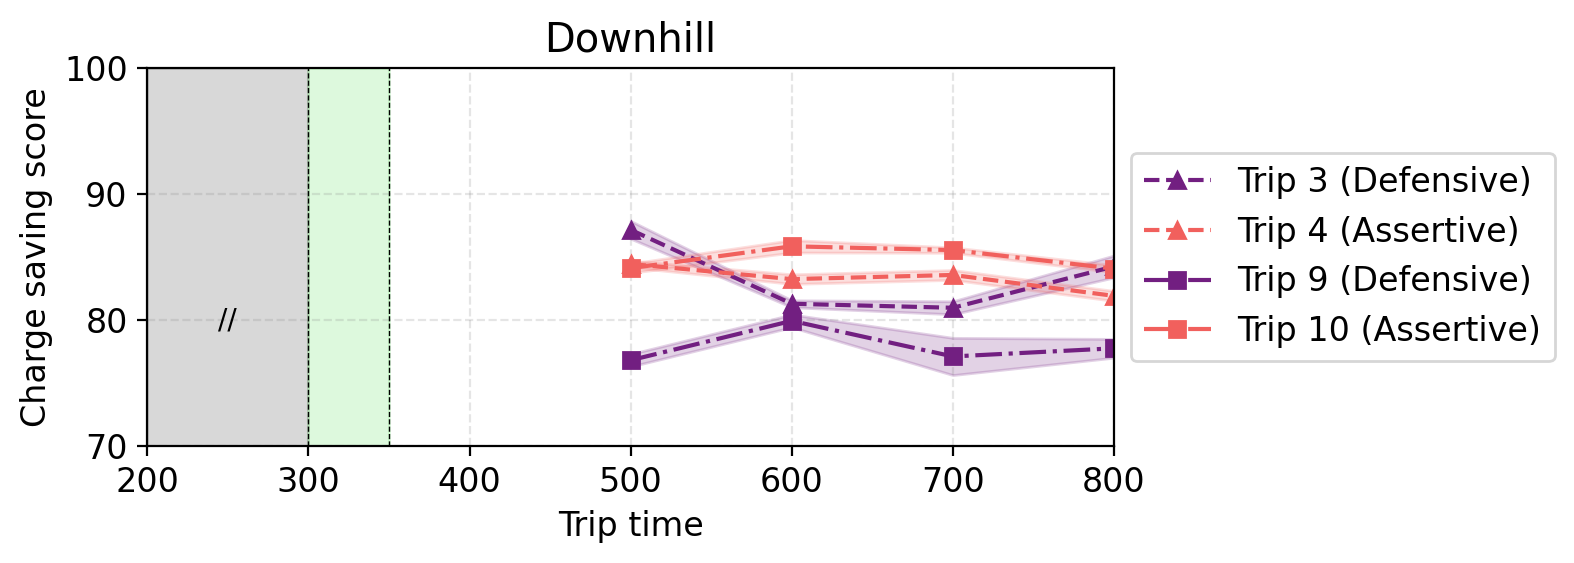

In [38]:
sns.reset_orig()
plt.rcdefaults()
plt.figure(figsize=(6, 3))
plt.rcParams['font.size'] = 12
colors = sns.color_palette("magma", 2)

time_frames = [500, 600, 700, 800]

plt.plot(time_frames, means_3, marker='^', label='Trip 3 (Defensive)', color=colors[0], linestyle="--")
plt.fill_between(time_frames, lb_3, ub_3, color=colors[0], alpha=0.2)
plt.plot(time_frames, means_4, marker='^', label='Trip 4 (Assertive)', color=colors[1], linestyle="--")
plt.fill_between(time_frames, lb_4, ub_4, color=colors[1], alpha=0.2)
plt.plot(time_frames, means_9, marker='s', label='Trip 9 (Defensive)', color=colors[0], linestyle="-.")
plt.fill_between(time_frames, lb_9, ub_9, color=colors[0], alpha=0.2)
plt.plot(time_frames, means_10, marker='s', label='Trip 10 (Assertive)', color=colors[1], linestyle="-.")
plt.fill_between(time_frames, lb_10, ub_10, color=colors[1], alpha=0.2)

plt.axvspan(200, 300, color='grey', alpha=0.3)
plt.axvspan(300, 350, color='lightgreen', alpha=0.3)
plt.axvline(300, color='black', linestyle='--', linewidth=0.5)
plt.axvline(350, color='black', linestyle='--', linewidth=0.5)
plt.grid(color="grey", alpha=0.2, linestyle="--")
plt.text(250, 80, "//", fontsize=10, va='center', ha='center', color='black')

plt.title('Downhill')
plt.xlabel('Trip time')
plt.ylabel('Charge saving score')
plt.ylim(70, 100)
plt.xlim(200, 800)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


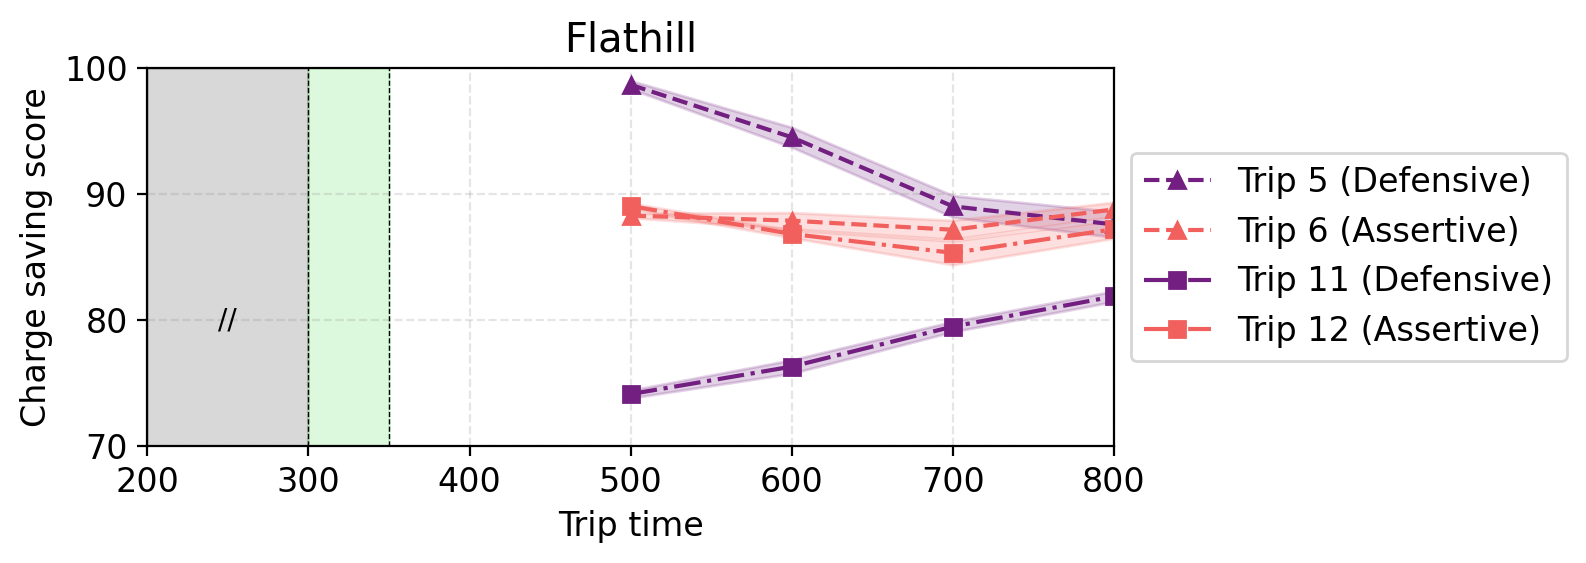

In [39]:
sns.reset_orig()
plt.rcdefaults()
plt.figure(figsize=(6, 3))
plt.rcParams['font.size'] = 12
colors = sns.color_palette("magma", 2)

time_frames = [500, 600, 700, 800]
plt.plot(time_frames, means_5, marker='^', label='Trip 5 (Defensive)', color=colors[0], linestyle="--")
plt.fill_between(time_frames, lb_5, ub_5, color=colors[0], alpha=0.2)
plt.plot(time_frames, means_6, marker='^', label='Trip 6 (Assertive)', color=colors[1], linestyle="--")
plt.fill_between(time_frames, lb_6, ub_6, color=colors[1], alpha=0.2)
plt.plot(time_frames, means_11, marker='s', label='Trip 11 (Defensive)', color=colors[0], linestyle="-.")
plt.fill_between(time_frames, lb_11, ub_11, color=colors[0], alpha=0.2)
plt.plot(time_frames, means_12, marker='s', label='Trip 12 (Assertive)', color=colors[1], linestyle="-.")
plt.fill_between(time_frames, lb_12, ub_12, color=colors[1], alpha=0.2)

plt.axvspan(200, 300, color='grey', alpha=0.3)
plt.axvspan(300, 350, color='lightgreen', alpha=0.3)
plt.axvline(300, color='black', linestyle='--', linewidth=0.5)
plt.axvline(350, color='black', linestyle='--', linewidth=0.5)
plt.grid(color="grey", alpha=0.2, linestyle="--")
plt.text(250, 80, "//", fontsize=10, va='center', ha='center', color='black')

plt.title('Flathill')
plt.xlabel('Trip time')
plt.ylabel('Charge saving score')
plt.ylim(70, 100)
plt.xlim(200, 800)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [40]:
classification_test

Defensive driving style  Assertive driving style  Downhill terrain  \
0                       1.0                      0.0               0.0   
1                       0.0                      1.0               0.0   
2                       1.0                      0.0               1.0   
3                       0.0                      1.0               1.0   
4                       1.0                      0.0               0.0   
5                       0.0                      1.0               0.0   
6                       1.0                      0.0               0.0   
7                       0.0                      1.0               0.0   
8                       1.0                      0.0               1.0   
9                       0.0                      1.0               1.0   
10                      1.0                      0.0               0.0   
11                      0.0                      1.0               0.0   

    Flat plane terrain  Uphill terrain  Charge & no rest (a)  \
0                  0.0             1.0                   1.0   
1                  0.0             1.0                   0.0   
2                  0.0             0.0                   0.0   
3                  0.0             0.0                   0.0   
4                  1.0             0.0                   1.0   
5                  1.0             0.0                   0.0   
6                  0.0             1.0                   0.0   
7                  0.0             1.0                   0.0   
8                  0.0             0.0                   1.0   
9                  0.0             0.0                   0.0   
10                 1.0             0.0                   0.0   
11                 1.0             0.0                   0.0   

    No charge & no rest (b)  No charge & no rest (c)  No charge & no rest (d)  \
0                       0.0                      0.0                      0.0   
1                       1.0                      0.0                      0.0   
2                       0.0                      1.0                      0.0   
3                       0.0                      0.0                      1.0   
4                       0.0                      0.0                      0.0   
5                       1.0                      0.0                      0.0   
6                       0.0                      1.0                      0.0   
7                       0.0                      0.0                      1.0   
8                       0.0                      0.0                      0.0   
9                       1.0                      0.0                      0.0   
10                      0.0                      1.0                      0.0   
11                      0.0                      0.0                      1.0   

    Charge & rest (a)  Charge & rest (b)  Charge & rest (c)  Cell ID (a)  \
0                 0.0                0.0                0.0          1.0   
1                 0.0                0.0                0.0          1.0   
2                 0.0                0.0                0.0          0.0   
3                 0.0                0.0                0.0          0.0   
4                 0.0                0.0                0.0          0.0   
5                 0.0                0.0                0.0          0.0   
6                 0.0                0.0                0.0          1.0   
7                 0.0                0.0                0.0          1.0   
8                 0.0                0.0                0.0          0.0   
9                 0.0                0.0                0.0          0.0   
10                0.0                0.0                0.0          0.0   
11                0.0                0.0                0.0          0.0   

    Cell ID (b)  Cell ID (c)  
0           0.0          0.0  
1           0.0          0.0  
2           1.0          0.0  
3           1.0          0.0  
4         

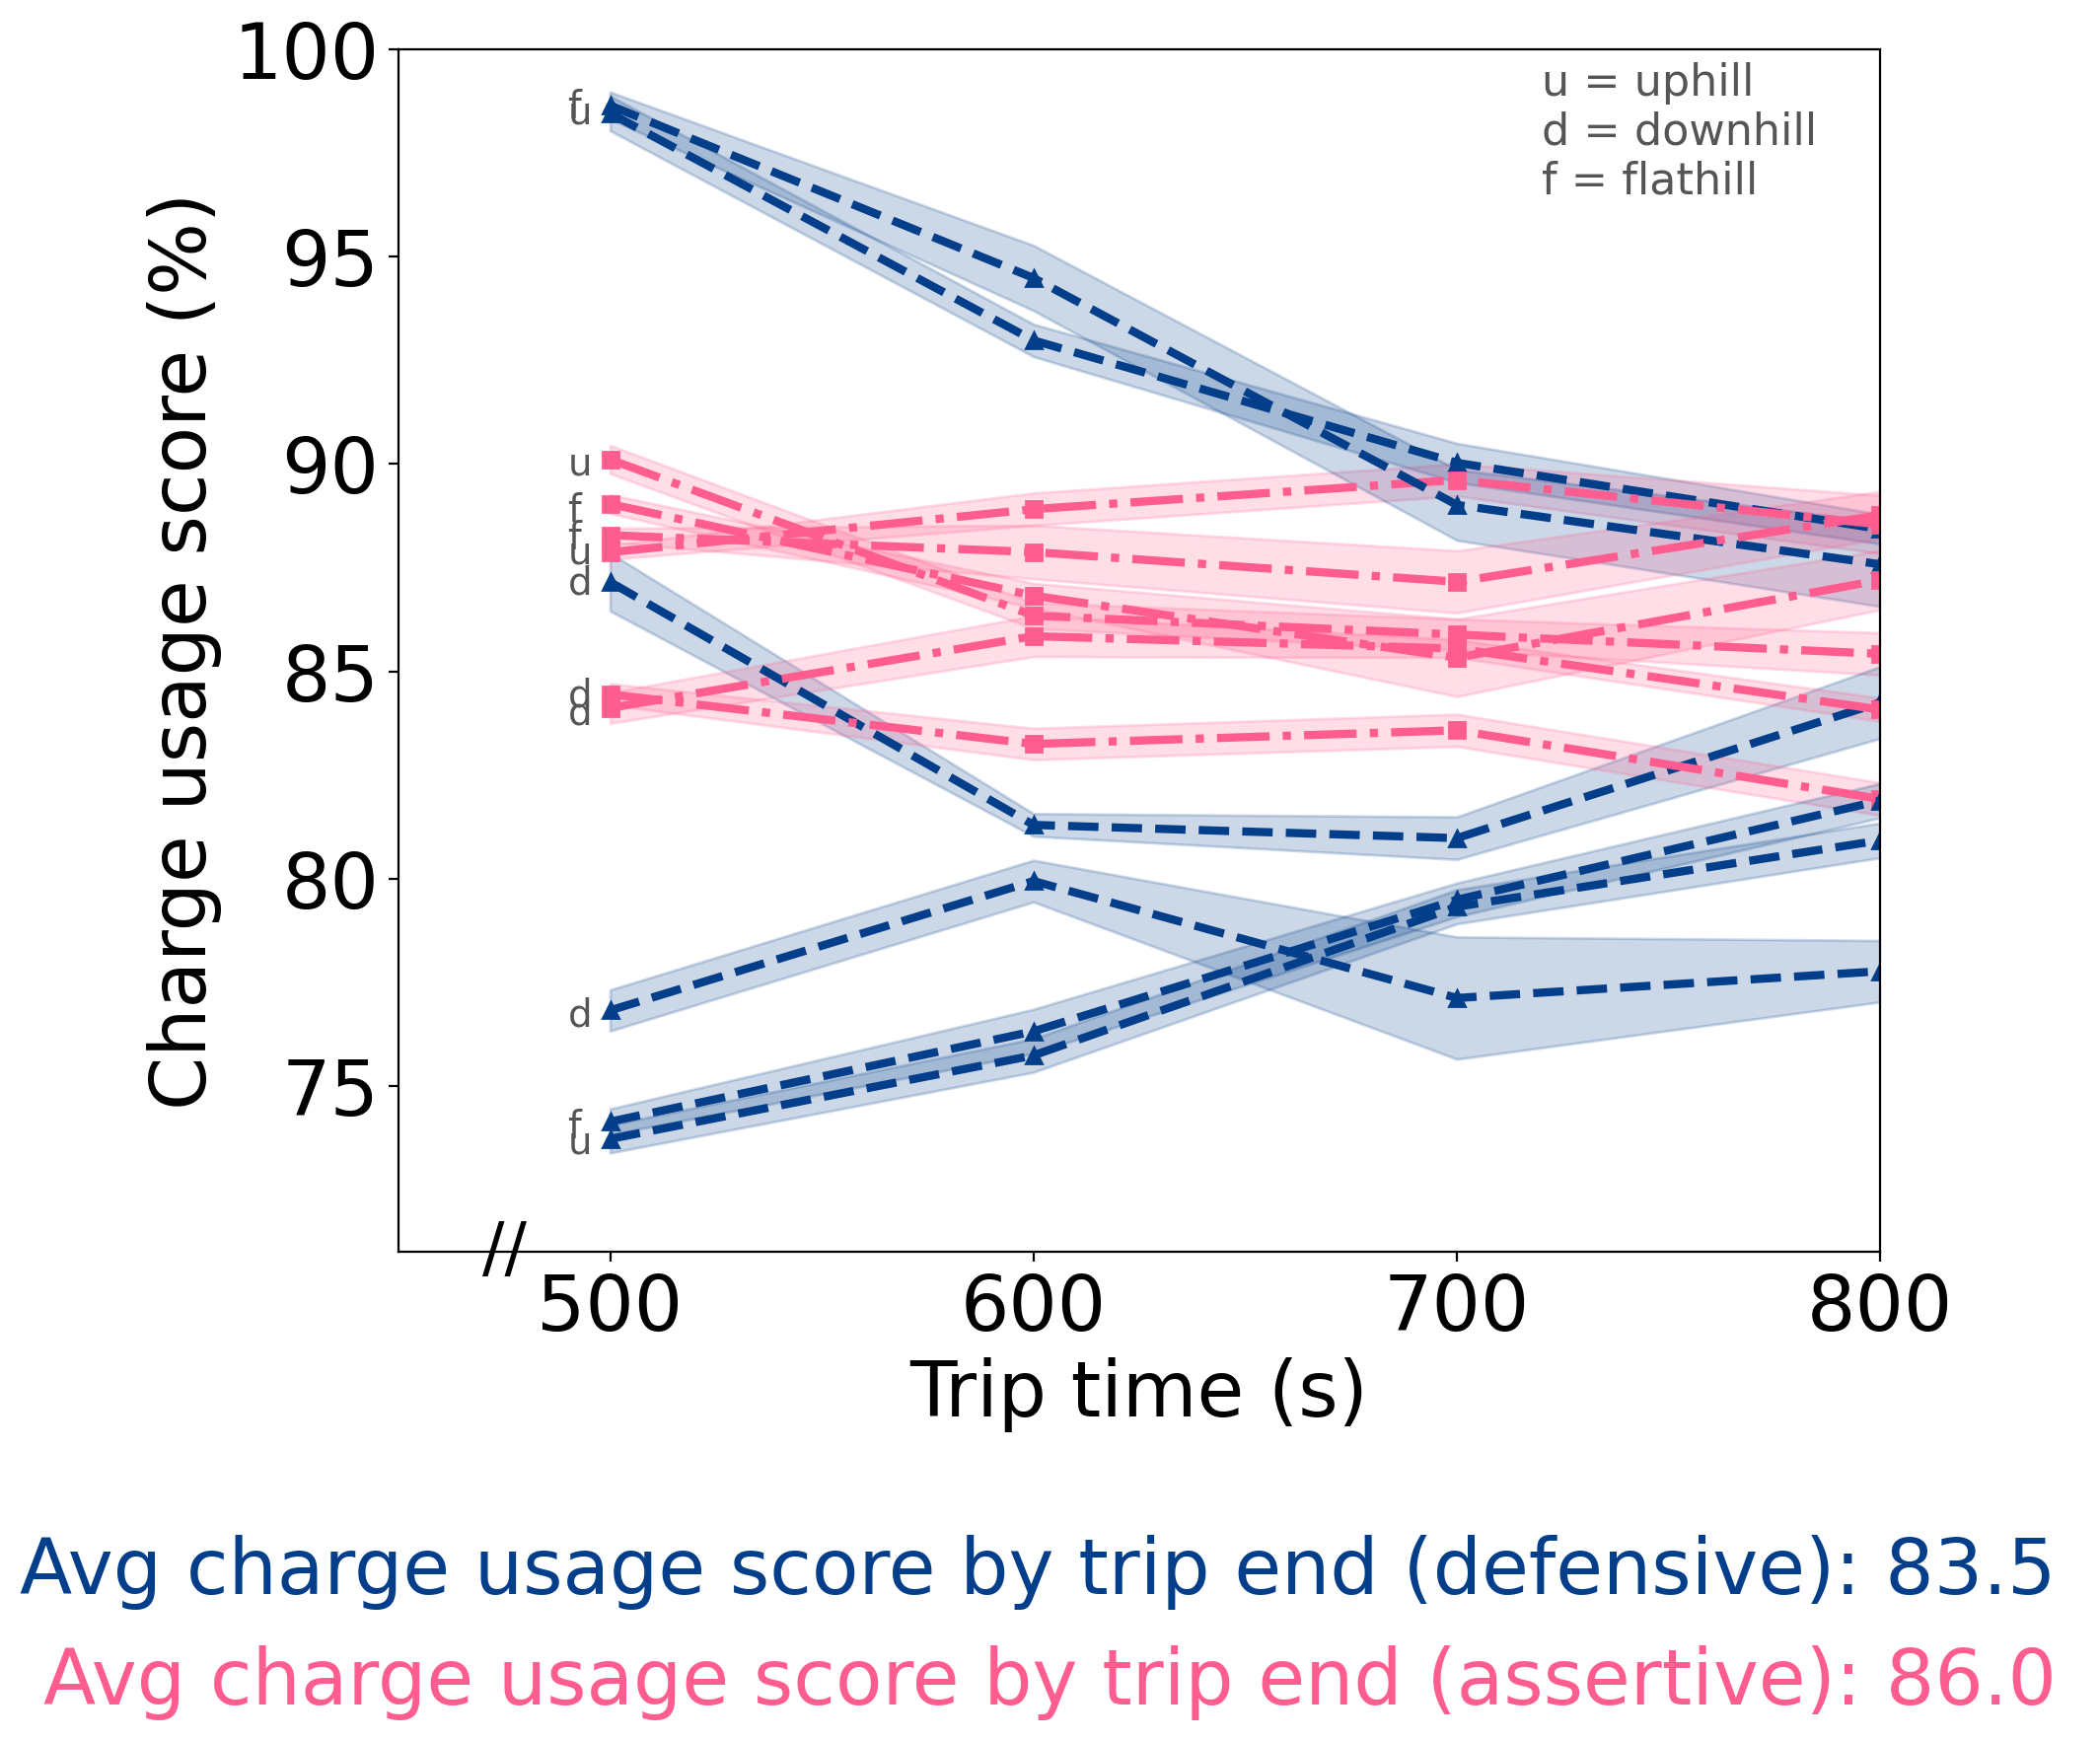

In [61]:
sns.reset_orig()
plt.rcdefaults()
plt.rcdefaults() 
fig = plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 28
time_frames = [500, 600, 700, 800]

plt.plot(time_frames, means_1, marker='^', label='Trip 1 (uphill)', color='#023e8a', linestyle="--", lw = 3)
plt.fill_between(time_frames, lb_1, ub_1, color='#023e8a', alpha=0.2)
plt.plot(time_frames, means_2, marker='s', label='Trip 2 (uphill)', color='#ff5d8f', linestyle="-.", lw = 3)
plt.fill_between(time_frames, lb_2, ub_2, color='#ff5d8f', alpha=0.2)
plt.plot(time_frames, means_7, marker='^', label='Trip 7 (uphill)', color='#023e8a', linestyle="--", lw = 3)
plt.fill_between(time_frames, lb_7, ub_7, color='#023e8a', alpha=0.2)
plt.plot(time_frames, means_8, marker='s', label='Trip 8 (uphill)', color='#ff5d8f', linestyle="-.", lw = 3)
plt.fill_between(time_frames, lb_8, ub_8, color='#ff5d8f', alpha=0.2)

plt.plot(time_frames, means_3, marker='^', label='Trip 3 (downhill)', color='#023e8a', linestyle="--", lw = 3)
plt.fill_between(time_frames, lb_3, ub_3, color='#023e8a', alpha=0.2)
plt.plot(time_frames, means_4, marker='s', label='Trip 4 (downhill)', color='#ff5d8f', linestyle="-.", lw = 3)
plt.fill_between(time_frames, lb_4, ub_4, color='#ff5d8f', alpha=0.2)
plt.plot(time_frames, means_9, marker='^', label='Trip 9 (downhill)', color='#023e8a', linestyle="--", lw = 3)
plt.fill_between(time_frames, lb_9, ub_9, color='#023e8a', alpha=0.2)
plt.plot(time_frames, means_10, marker='s', label='Trip 10 (downhill)', color='#ff5d8f', linestyle="-.", lw = 3)
plt.fill_between(time_frames, lb_10, ub_10, color='#ff5d8f', alpha=0.2)

plt.plot(time_frames, means_5, marker='^', label='Trip 5 (flathill)', color='#023e8a', linestyle="--", lw = 3)
plt.fill_between(time_frames, lb_5, ub_5, color='#023e8a', alpha=0.2)
plt.plot(time_frames, means_6, marker='s', label='Trip 6 (flathill)', color='#ff5d8f', linestyle="-.", lw = 3)
plt.fill_between(time_frames, lb_6, ub_6, color='#ff5d8f', alpha=0.2)
plt.plot(time_frames, means_11, marker='^', label='Trip 11 (flathill)', color='#023e8a', linestyle="--", lw = 3)
plt.fill_between(time_frames, lb_11, ub_11, color='#023e8a', alpha=0.2)
plt.plot(time_frames, means_12, marker='s', label='Trip 12 (flathill)', color='#ff5d8f', linestyle="-.", lw = 3)
plt.fill_between(time_frames, lb_12, ub_12, color='#ff5d8f', alpha=0.2)

plt.axvspan(200, 300, color='grey', alpha=0.3)
plt.axvspan(300, 350, color='lightgreen', alpha=0.3)
plt.axvline(300, color='black', linestyle='--', linewidth=0.5)
plt.axvline(350, color='black', linestyle='--', linewidth=0.5)
# plt.grid(color="grey", alpha=0.2, linestyle="--")
# plt.gca().set_axisbelow(True)
plt.text(475, 71, "//", fontsize=24, va='center', ha='center', color='black')

# Define terrain labels for each trip
terrain_labels = ['u', 'u', 'd', 'd', 'f', 'f', 'u', 'u', 'd', 'd', 'f', 'f']

# Annotate at the start of each line (500 sec)
for i, (trip, label) in enumerate(zip(
    [means_1, means_2, means_3, means_4, means_5, means_6, 
     means_7, means_8, means_9, means_10, means_11, means_12],
    terrain_labels)):

    plt.text(490, trip[0] - (i) * 0.015 ,  # Slight vertical offset to avoid overlap
             label, 
             color='#555555', 
             fontsize=14, 
             va='center')

defensive_trips = [means_1[-1], means_3[-1], means_5[-1], means_7[-1], means_9[-1], means_11[-1]]
assertive_trips = [means_2[-1], means_4[-1], means_6[-1], means_8[-1], means_10[-1], means_12[-1]]

# Calculate average scores
avg_defensive = np.mean(defensive_trips)
avg_assertive = np.mean(assertive_trips)

# Add the average annotations at the bottom of the plot
plt.figtext(0.5, - 0.05,  # Adjust y for positioning below the plot
            f'Avg charge usage score by trip end (defensive): {avg_defensive:.1f} ', 
            ha='center', fontsize=28, color='#023e8a')

plt.figtext(0.5, -.12,  
            f'Avg charge usage score by trip end (assertive): {avg_assertive:.1f}', 
            ha='center', fontsize=28, color='#ff5d8f')

# Create custom legend handles
legend_elements = [
    Line2D([0], [0], color='#023e8a', lw=2, linestyle='--', label='Defensive'),
    Line2D([0], [0], color='#ff5d8f', lw=2, linestyle='-.', label='Assertive')]

# Add custom legend to plot
# plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.18, 1))
# Add terrain legend as text box
# Add terrain legend as text box
plt.text(720, 98,
         'u = uphill\n'
         'd = downhill\n'
         'f = flathill', 
         ha='left', va='center', fontsize=16,
         color='#555555',
         bbox={'facecolor': 'white', 'alpha': 0, 'edgecolor': 'lightgrey'})  # Correct bbox format


plt.xlabel('Trip time (s)')
plt.ylabel('Charge usage score (%)')
plt.ylim(71, 100)
plt.xlim(450, 800)
plt.tight_layout()
fig.savefig(PLOT_DIR / 'early_feedback.svg', format='svg', dpi=2000, bbox_inches='tight')
plt.show()

In [42]:
defensive_trips = [means_1[-1], means_3[-1], means_5[-1], means_7[-1], means_9[-1], means_11[-1]]
assertive_trips = [means_2[-1], means_4[-1], means_6[-1], means_8[-1], means_10[-1], means_12[-1]]

# Compute averages
avg_defensive = np.mean(defensive_trips)
avg_assertive = np.mean(assertive_trips)

print("Average Defensive value at x=800:", avg_defensive)
print("Average Assertive value at x=800:", avg_assertive)

Average Defensive value at x=800: 83.47745055607645
Average Assertive value at x=800: 85.99232467636222
